In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

folder_path = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw"

os.path.exists(folder_path)

Mounted at /content/drive


True

In [2]:
!pip install pyBigWig
from google.colab import drive
import os
import pyBigWig
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.preprocessing import StandardScaler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 3.5 MB/s eta 0:00:00


# What this cell does (one-liner)

It opens a bigWig track, prints basic genome metadata, samples multiple random 10 kb windows from canonical chromosomes, and reports summary stats + zero/NaN fractions and a histogram of the sampled signal.

# Inputs & assumptions

- bw = pyBigWig.open(folder_path): folder_path must actually be the path to a .bigWig file, not a directory.

- Canonical chromosomes only: chr1–chr22, chrX, chrY.

- Window sampling: WIN = 10,000 bp, N_WINDOWS = 20.

# Step-by-step

1. **Metadata**

- bw.chroms() lists chromosomes and their lengths.

- Prints keys (chrom names) and the total genome size (sum of lengths).

2. **Whole-chrom quick stat**

- bw.stats(chrom, 0, chrom_len, type="mean") returns a list with the mean signal over that chromosome (you’re using the first chrom in the dict).

3. **Random window sampling (across canonical chroms)**

- Filters to chromosomes in CANON with length ≥ WIN.

- For each of N_WINDOWS: picks a random chrom and start, retrieves vals = bw.values(...).

- Tracks:

  - total_count: total bases sampled,

  - nan_count: how many NaNs (missing / off-track),

  - zero_count: how many exact zeros among non-NaNs,

  - all_vals: keeps all sampled arrays to later concatenate.

4. **Summaries + histogram**

- Concatenates all_vals, drops NaNs to get clean.

- Prints min/max/mean (NaN-aware), zero fraction (among non-NaNs), and overall NaN fraction.

- Plots a histogram of the non-NaN values.

# Why this is useful

- **Fast sanity check**: confirms the file opens, chromosomes look right, and values are in a reasonable range.

- **Sparsity check**: zero/NaN fractions tell you whether the track is sparse (e.g., WGBS) or dense (e.g., ATAC coverage).

- **Distribution shape**: histogram reveals whether the signal is bimodal (WGBS), heavy-tailed (ATAC/ChIP), etc.

Chromosomes: dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM', 'chr1_KI270706v1_random', 'chr1_KI270707v1_random', 'chr1_KI270708v1_random', 'chr1_KI270709v1_random', 'chr1_KI270710v1_random', 'chr1_KI270711v1_random', 'chr1_KI270712v1_random', 'chr1_KI270713v1_random', 'chr1_KI270714v1_random', 'chr2_KI270715v1_random', 'chr2_KI270716v1_random', 'chr3_GL000221v1_random', 'chr4_GL000008v2_random', 'chr5_GL000208v1_random', 'chr9_KI270717v1_random', 'chr9_KI270718v1_random', 'chr9_KI270719v1_random', 'chr9_KI270720v1_random', 'chr11_KI270721v1_random', 'chr14_GL000009v2_random', 'chr14_GL000225v1_random', 'chr14_KI270722v1_random', 'chr14_GL000194v1_random', 'chr14_KI270723v1_random', 'chr14_KI270724v1_random', 'chr14_KI270725v1_random', 'chr14_KI270726v1_random', 'chr15_KI270727v1_random', 'chr16_KI270728v1_random'

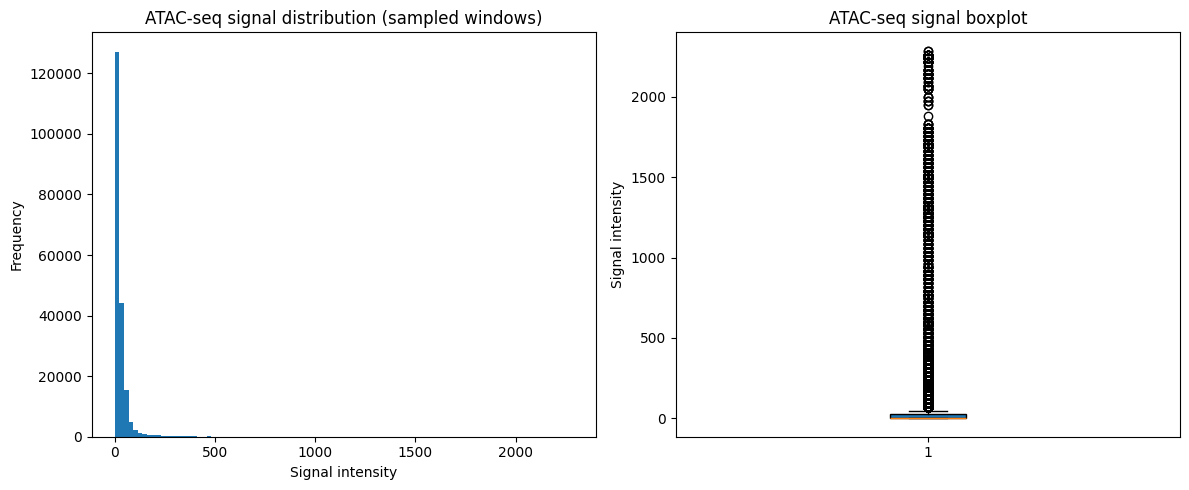

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pyBigWig

# ---- Open bigWig ----
bw = pyBigWig.open(folder_path)

# 1) Basic metadata
chrom_dict = bw.chroms()
print("Chromosomes:", chrom_dict.keys())
print("Total bases covered:", sum(chrom_dict.values()))

# 2) File-wide example mean
first_chrom = next(iter(chrom_dict))
first_len = chrom_dict[first_chrom]
stats = bw.stats(first_chrom, 0, first_len, type="mean")
print("Example mean signal:", stats)

# 3) Random window sampling
WIN = 10_000
N_WINDOWS = 20
CANON = {f"chr{i}" for i in range(1, 23)} | {"chrX", "chrY"}

chroms = {c: L for c, L in chrom_dict.items() if c in CANON and L >= WIN}
if not chroms:
    bw.close()
    raise ValueError("No chromosomes >= window size; reduce WIN or check genome build.")

print("Using chromosomes:", sorted(chroms))

all_vals = []
zero_count = 0
nan_count = 0
total_count = 0

for _ in range(N_WINDOWS):
    chrom = random.choice(list(chroms.keys()))
    length = chroms[chrom]
    start = random.randint(0, length - WIN)
    end = start + WIN

    vals = bw.values(chrom, start, end, numpy=True)
    if vals is None:
        continue

    total_count += vals.size
    nan_mask = np.isnan(vals)
    nan_count += np.sum(nan_mask)
    zero_count += np.sum((~nan_mask) & (vals == 0))
    all_vals.append(vals)

bw.close()

# Flatten, compute stats
if not all_vals:
    raise RuntimeError("No windows were collected; check input file or parameters.")

all_vals = np.concatenate(all_vals)
clean_vals = all_vals[~np.isnan(all_vals)]

print(f"Sampled {N_WINDOWS} windows of {WIN} bp each.")
print("Min / Max / Mean:", np.nanmin(all_vals), np.nanmax(all_vals), np.nanmean(all_vals))
print("Zero fraction (non-NaN):", zero_count / np.sum(~np.isnan(all_vals)))
print("NaN fraction:", nan_count / total_count)

zeros = np.sum(all_vals == 0)
nans = np.sum(np.isnan(all_vals))
print("Zero fraction (global):", zeros / len(all_vals))
print("NaN fraction (global):", nans / len(all_vals))

# ---- PLOTS ----
if clean_vals.size == 0:
    print("All sampled values are NaN; skipping plots.")
else:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(clean_vals, bins=100)
    plt.title("ATAC-seq signal distribution (sampled windows)")
    plt.xlabel("Signal intensity")
    plt.ylabel("Frequency")

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(clean_vals, vert=True, patch_artist=True)
    plt.title("ATAC-seq signal boxplot")
    plt.ylabel("Signal intensity")

    plt.tight_layout()
    plt.show()


# What this cell does (one-liner)

It tiles the canonical chromosomes into 1 kb windows, reads values from a bigWig (bw) for each window, computes mean and max signal per window, builds a tidy dataframe, applies log1p transforms, filters to non-zero windows, and prints progress throughout.

# Inputs & assumptions

- bw: an already opened pyBigWig object (e.g., ATAC, methylation, ChIP).

- BIN = 1000: window size (bp) for tiling.

- CANON: chromosomes to include (chr1–22, X, Y).

- Signal semantics depend on the track (e.g., ATAC = coverage; WGBS = fractional methylation, sparse & NaN off-CpG).

# Step-by-step

1. **Progress header**
Prints bin size and the chromosome list for quick sanity checking.

2. **Chromosome loop**
Skips non-canonical contigs; for each included chrom:

- Reports chromosome length and computes n_bins.

3. **Window loop (per chrom)**
For each 1 kb window:

- vals = bw.values(chrom, start, end, numpy=True) pulls the per-base (or binned) signal.

- vals = vals[~np.isnan(vals)] drops NaNs (missing or out-of-track positions).

- If no values remain:

  - sets mean = maxv = 0 (see caveat below).

- Else:

  - mean = np.mean(vals) and maxv = np.max(vals).

- Appends a row: (chrom, start, end, mean, maxv).

- Prints a progress tick every 50k windows.

4. **Per-chrom summary**
Prints how many windows were processed.

5. **Build dataframe**
df = pd.DataFrame(rows, columns=[…]) and reports total row count.

6. **Transforms**

- log_mean = log1p(mean_signal) and log_max = log1p(max_signal) to stabilize heavy-tailed signals (safe on zeros).

7. **Filter**

- df_nonzero = df[df["mean_signal"] > 0] creates a subset of windows with non-zero mean signal.

8. **Return/preview**
Prints completion and shows df.head().

# Why these choices make sense

- **1 kb windows**: fine granularity for many assays; easy to aggregate later to 5–10 kb (e.g., to match Hi-C).

- **mean + max**: complementary—mean captures overall activity; max is sensitive to sharp peaks.

- **log1p**: common variance-stabilizer for count-like data; keeps zeros defined.

- **progress prints**: long genomes + small bins can take time; logs reassure you it’s working.

# Important caveat (worth fixing)

When a window has no valid values, the code sets mean = maxv = 0.
For sparse tracks (e.g., WGBS, where only CpGs have values), this conflates “no data” with “true zero signal”. That can bias downstream analyses and inflate “zero” counts.

Better: store NaN for empty windows, then decide downstream how to handle them:
```
if len(vals) == 0:
    mean, maxv = np.nan, np.nan
```

You can still create a “non-NaN” view later with df.dropna(subset=["mean_signal"]).

# How to interpret the outputs

- df contains every 1 kb window (canonical chromosomes only) with:

  - mean_signal: average track value in the window (0 or NaN if no data, depending on your choice).

  - max_signal: strongest base/bin in the window.

  - log_mean, log_max: log1p-transformed versions, useful for correlations/plots.

- df_nonzero removes windows where mean_signal == 0 (note the caveat).

# Knobs you can tune

- **Speed vs resolution**: increase BIN to 5_000 or 10_000 for faster runs and to align with 10 kb Hi-C.

- **Chrom set**: adjust CANON (e.g., autosomes only).

- **Statistics**: compute median, std, %>threshold, or coverage fraction:
```
cov = (vals > 0).mean() if len(vals) else np.nan
```

- **I/O**: save df to CSV/Parquet after creation.

In [ ]:
import pyBigWig, numpy as np, pandas as pd

# Open the bigWig file again (set your file path here)
folder_path = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw"
bw = pyBigWig.open(folder_path)

BIN = 1000   # 1 kb windows
CANON = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY"]

rows = []

print("✅ Starting Level 1 genome binning...")
print(f"Using bin size: {BIN} bp")
print(f"Chromosomes included: {CANON}\n")

for chrom, length in bw.chroms().items():
    if chrom not in CANON:
        continue

    print(f"⏳ Processing {chrom} (length: {length:,} bp)...", flush=True)

    n_bins = (length // BIN) + 1
    processed = 0

    for start in range(0, length, BIN):
        end = min(start + BIN, length)
        vals = bw.values(chrom, start, end, numpy=True)

        if vals is None:
            continue

        vals = vals[~np.isnan(vals)]
        if len(vals) == 0:
            mean = maxv = 0
        else:
            mean = np.mean(vals)
            maxv = np.max(vals)

        rows.append((chrom, start, end, mean, maxv))

        # Print progress every 50k bins
        processed += 1
        if processed % 50_000 == 0:
            print(f"   → {processed:,}/{n_bins:,} windows done", flush=True)

    print(f"✅ Finished {chrom}: {n_bins:,} windows\n")

bw.close()  # ✅ close AFTER the loop is fully done

print("🎉 Finished binning all chromosomes. Creating dataframe...")
df = pd.DataFrame(rows, columns=["chrom", "start", "end", "mean_signal", "max_signal"])
print(f"✅ Dataframe created with {len(df):,} rows")

# ---- Transformations ----
print("📌 Applying log transform (log1p)...")
df["log_mean"] = np.log1p(df["mean_signal"])
df["log_max"]  = np.log1p(df["max_signal"])

print("📌 Removing windows with zero signal...")
df_nonzero = df[df["mean_signal"] > 0]
print(f"   → {len(df_nonzero):,} non-zero windows out of {len(df):,}")

print("\n✅ Level 1 processing complete!")
df.head()


✅ Starting Level 1 genome binning...
Using bin size: 1000 bp
Chromosomes included: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

⏳ Processing chr1 (length: 248,956,422 bp)...
   → 50,000/248,957 windows done
   → 100,000/248,957 windows done
   → 150,000/248,957 windows done
   → 200,000/248,957 windows done
✅ Finished chr1: 248,957 windows

⏳ Processing chr2 (length: 242,193,529 bp)...
   → 50,000/242,194 windows done
   → 100,000/242,194 windows done
   → 150,000/242,194 windows done
   → 200,000/242,194 windows done
✅ Finished chr2: 242,194 windows

⏳ Processing chr3 (length: 198,295,559 bp)...
   → 50,000/198,296 windows done
   → 100,000/198,296 windows done
   → 150,000/198,296 windows done
✅ Finished chr3: 198,296 windows

⏳ Processing chr4 (length: 190,214,555 bp)...
   → 50,000/190,215 windows done
   → 100,000/190,215

,chrom,start,end,mean_signal,max_signal,log_mean,log_max
0,chr1,0,1000,0.0,0.0,0.0,0.0
1,chr1,1000,2000,0.0,0.0,0.0,0.0
2,chr1,2000,3000,0.0,0.0,0.0,0.0
3,chr1,3000,4000,0.0,0.0,0.0,0.0
4,chr1,4000,5000,0.0,0.0,0.0,0.0


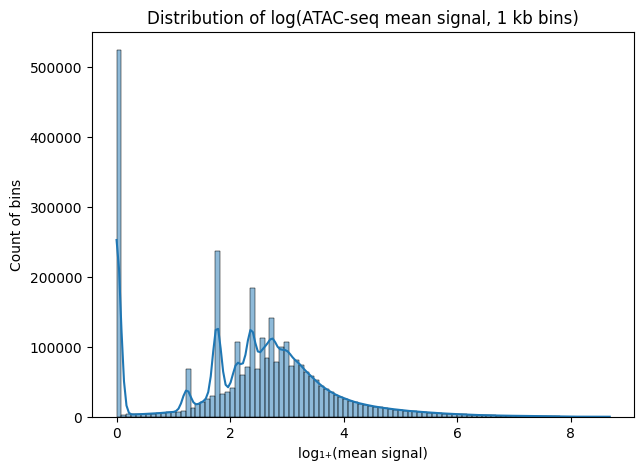

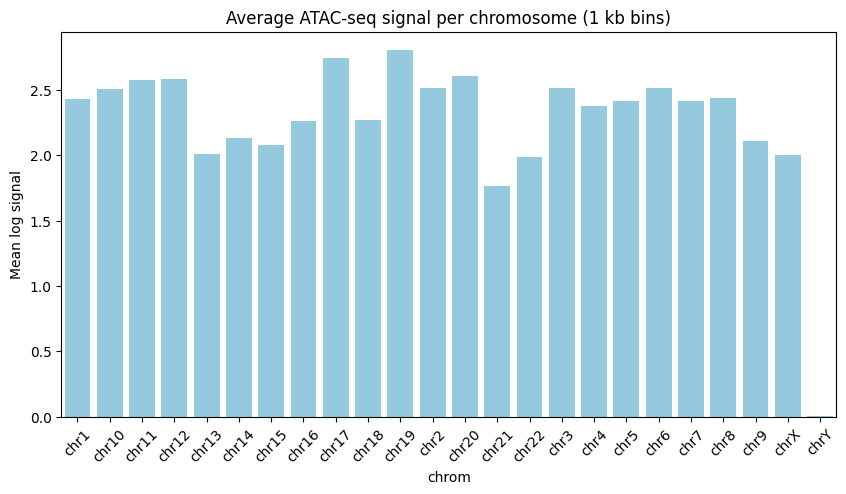

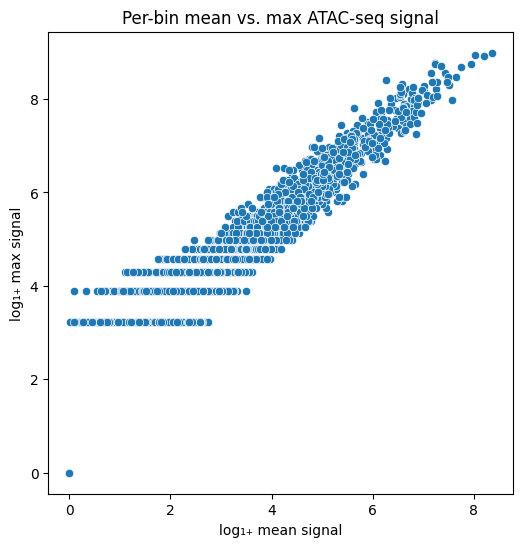

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.histplot(df["log_mean"], bins=100, kde=True)
plt.title("Distribution of log(ATAC-seq mean signal, 1 kb bins)")
plt.xlabel("log₁₊(mean signal)")
plt.ylabel("Count of bins")
plt.show()

chrom_means = df.groupby("chrom")["log_mean"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=chrom_means, x="chrom", y="log_mean", color="skyblue")
plt.title("Average ATAC-seq signal per chromosome (1 kb bins)")
plt.ylabel("Mean log signal")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(x="log_mean", y="log_max", data=df.sample(10000))
plt.title("Per-bin mean vs. max ATAC-seq signal")
plt.xlabel("log₁₊ mean signal")
plt.ylabel("log₁₊ max signal")
plt.show()




In [ ]:
df.groupby("chrom")["mean_signal"].mean().sort_values(ascending=False)


,mean_signal
chrom,
chr19,67.551811
chr17,54.621960
chr11,40.047241
chr20,38.442856
chr16,37.993385
chr22,37.372601
chr1,36.558891
chr12,36.306396
chr10,33.329418


# What this cell does (one-liner)

It computes per-chromosome correlations between ATAC accessibility and Hi-C interaction strength by (1) converting each Hi-C diagonal .npz into a 1D per-bin interaction signal, (2) aligning your Level-1 ATAC bins to the same Hi-C grid, and (3) reporting Pearson and Spearman correlations for every chromosome file.

# Inputs & assumptions

- ATAC_DF = df: Level-1 ATAC dataframe with chrom, start, end, log_mean (or other column named in ATAC_COL).

- HIC_DIR: folder of Hi-C diagonal‐stack .npz files (keys '0','±1','±2',…')—typically one file per chromosome.

- Resolution: inferred per chromosome by infer_hic_bin_bp_from_df using chrom_len / diag_len, rounded to the nearest kb (usually 10 kb for your data).

- K = 5: sums ±5 off-diagonals around the main diagonal to capture ~100 kb local neighborhood.

- Hi-C signal is log1p-transformed (variance stabilization).

# How it works step-by-step

1. **Main loop**
Finds all *.npz in HIC_DIR. For each file, it infers the chromosome name (e.g., chr1) and calls correlate_one.

2. **Build Hi-C 1D signal** (build_hic_signal_from_diagonals)

- Starts with the main diagonal ('0') and adds the first K upper and lower diagonals, aligned so each bin’s value becomes a local interaction strength (broader than self-contacts).

- Applies np.log1p to down-weight extreme counts.

3. **Infer bin size** (infer_hic_bin_bp_from_df)

- Uses the maximum end coordinate in your ATAC df for that chromosome as a chrom length proxy and divides by the Hi-C diagonal length to estimate bp per bin (rounded to nearest kb).

- Prints the inferred bin (e.g., ≈10 kb) so you can sanity-check resolution.

4. **Map ATAC to the Hi-C grid**

- For the current chromosome, computes hic_bin = start // hic_bin_bp.

- Averages ATAC (ATAC_COL, default log_mean) within each hic_bin.

- Drops bins beyond the Hi-C length and merges with the Hi-C 1D signal.

5. **Correlate**

- Extracts paired arrays (ATAC per bin, Hi-C per bin).

- Computes Pearson r (linear association) and Spearman ρ (rank/monotonic association).

- Prints the results and returns a record with: chrom, diag_len, hic_bin_bp, chrom_len_bp, bins_used, pearson_r/p, spearman_rho/p.

6. **Collect & summarize**

- Aggregates all per-chromosome records into summary (sorted by chrom) and prints “All chromosomes processed.”

# Why these design choices

- **±K diagonal summation**: captures a biologically meaningful neighborhood around each bin (not just self or +1 bin), improving correlation with functional signals.

- **log1p on Hi-C**: Hi-C contacts are heavy-tailed; log1p stabilizes without breaking zeros.

- **Auto-inferring bin size**: prevents mismatches if your files or chrom sizes vary (still easy to hard-set to exactly 10 kb if you prefer).

- **Pearson + Spearman**: ATAC often behaves approximately log-normal (Pearson useful) but adding Spearman guards against nonlinearity/outliers.

# How to interpret the output

- diag_len: number of Hi-C bins (e.g., ~24,896 for chr1 at 10 kb).

- hic_bin_bp: inferred resolution (should be ~10,000 for your data).

- bins_used: number of overlapping bins between ATAC and Hi-C after mapping.

- **Pearson r**: linear association strength; for clean bulk data at 10 kb with moderate K, 0.4–0.8 is typical.

- **Spearman ρ**: monotonic association; should be similar or slightly higher than Pearson if relationships are non-linear or there are outliers.

# Common pitfalls it avoids

- **Resolution mismatch** (auto-inference + bin mapping).

- **Misaligned diagonals** (properly aligns +d to [0:N-d) and −d to [d:N)).

- **Dominance of extreme Hi-C values** (log1p).

- **Silent failures** (verbose progress prints per chromosome).

# Knobs you can tune

- **Context scale**: change K (e.g., 1, 2, 10, 20). Larger K usually increases coupling to epigenetic state.

- **ATAC statistic**: switch ATAC_COL to mean_signal (raw) or use a robust statistic upstream (median).

- **Fix resolution**: if you know bins are exactly 10 kb, bypass inference and hard-set hic_bin_bp=10_000.

- **Scatter plot**: set DO_SCATTER=True for quick per-chrom visual checks.

In [ ]:
import glob, re, os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# ---- USER SETTINGS ----
ATAC_DF = df      # your Level-1 dataframe
HIC_DIR = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/hic_matrix"
ATAC_COL = "log_mean"
K = 5                   # number of ± diagonals to sum
DO_SCATTER = False      # set True to plot per-chrom scatter
# -----------------------


def build_hic_signal_from_diagonals(f, K):
    N = f['0'].shape[0]
    hic_signal = np.zeros(N, dtype=float)
    hic_signal += f['0']
    for d in range(1, K+1):
        if str(d) in f.files:
            hic_signal[:N-d] += f[str(d)]
        if f"-{d}" in f.files:
            hic_signal[d:] += f[f"-{d}"]
    return np.log1p(hic_signal)


def infer_hic_bin_bp_from_df(df_atac, chrom, diag_len):
    sub = df_atac[df_atac["chrom"] == chrom]
    if sub.empty:
        raise ValueError(f"No ATAC rows for {chrom}")
    chrom_len = int(sub["end"].max())
    bin_bp = int(round(chrom_len / diag_len / 1000.0)) * 1000
    return bin_bp, chrom_len


def correlate_one(npz_path, df_atac, atac_col, K, scatter=False):
    basename = os.path.basename(npz_path)
    m = re.search(r"(chr[0-9XYM]+)", basename)
    if not m:
        raise ValueError(f"Cannot infer chromosome: {basename}")
    chrom = m.group(1)

    print(f"\n🔹 Loading Hi-C file: {basename}  →  {chrom}")
    f = np.load(npz_path)
    N = f['0'].shape[0]

    hic_bin_bp, chrom_len = infer_hic_bin_bp_from_df(df_atac, chrom, N)
    print(f"   • Diagonal length = {N:,} bins")
    print(f"   • Inferred Hi-C bin size ≈ {hic_bin_bp//1000} kb (chrom size ≈ {chrom_len:,} bp)")

    print(f"   • Building Hi-C per-bin interaction signal (±{K} diagonals)...", end="", flush=True)
    hic_signal = build_hic_signal_from_diagonals(f, K)
    print(" done ✅")

    print(f"   • Mapping ATAC → same bins...", end="", flush=True)
    sub = df_atac[df_atac["chrom"] == chrom].copy()
    sub["hic_bin"] = (sub["start"] // hic_bin_bp).astype(int)
    atac_binned = (
        sub.groupby("hic_bin", as_index=False)[atac_col]
           .mean()
           .rename(columns={atac_col: "atac_signal"})
    )
    atac_binned = atac_binned[atac_binned["hic_bin"] < N]
    print(f" {len(atac_binned):,} bins matched")

    hic_df = pd.DataFrame({"hic_bin": np.arange(N), "hic_signal": hic_signal})
    merged = atac_binned.merge(hic_df, on="hic_bin", how="inner").sort_values("hic_bin")

    x, y = merged["atac_signal"].to_numpy(), merged["hic_signal"].to_numpy()
    pear = pearsonr(x, y)
    spear = spearmanr(x, y)

    print(f"   • Correlation complete → Pearson r={pear.statistic:.3f}, Spearman ρ={spear.correlation:.3f}")

    if scatter:
        import matplotlib.pyplot as plt
        plt.scatter(x, y, s=3, alpha=0.3)
        plt.xlabel(f"ATAC ({atac_col}, per {hic_bin_bp//1000} kb)")
        plt.ylabel(f"Hi-C signal (log1p, ±{K})")
        plt.title(f"{chrom}: r={pear.statistic:.2f}, ρ={spear.correlation:.2f}")
        plt.show()

    return {
        "chrom": chrom,
        "diag_len": N,
        "hic_bin_bp": hic_bin_bp,
        "chrom_len_bp": chrom_len,
        "bins_used": len(merged),
        "pearson_r": pear.statistic,
        "pearson_p": pear.pvalue,
        "spearman_rho": spear.correlation,
        "spearman_p": spear.pvalue
    }


# ---- MAIN LOOP ----
files = sorted(glob.glob(os.path.join(HIC_DIR, "*.npz")))
print(f"✅ Found {len(files)} Hi-C files in folder\n")

results = []
for i, path in enumerate(files, 1):
    print(f"===============================  [{i}/{len(files)}]  ===============================")
    try:
        out = correlate_one(path, ATAC_DF, ATAC_COL, K, scatter=DO_SCATTER)
        results.append(out)
    except Exception as e:
        print(f"⚠️ Skipping {os.path.basename(path)} → {e}")

summary = pd.DataFrame(results).sort_values("chrom")
print("\n✅ All chromosomes processed.")
summary




✅ Found 23 Hi-C files in folder

===============================  [1/23]  ===============================

🔹 Loading Hi-C file: chr1.npz  →  chr1
   • Diagonal length = 24,896 bins
   • Inferred Hi-C bin size ≈ 10 kb (chrom size ≈ 248,956,422 bp)
   • Building Hi-C per-bin interaction signal (±5 diagonals)... done ✅
   • Mapping ATAC → same bins... 24,896 bins matched
   • Correlation complete → Pearson r=0.733, Spearman ρ=0.585
===============================  [2/23]  ===============================

🔹 Loading Hi-C file: chr10.npz  →  chr10
   • Diagonal length = 13,380 bins
   • Inferred Hi-C bin size ≈ 10 kb (chrom size ≈ 133,797,422 bp)
   • Building Hi-C per-bin interaction signal (±5 diagonals)... done ✅
   • Mapping ATAC → same bins... 13,380 bins matched
   • Correlation complete → Pearson r=0.482, Spearman ρ=0.544
===============================  [3/23]  ===============================

🔹 Loading Hi-C file: chr11.npz  →  chr11
   • Diagonal length = 13,509 bins
   • Inferred H

,chrom,diag_len,hic_bin_bp,chrom_len_bp,bins_used,pearson_r,pearson_p,spearman_rho,spearman_p
0,chr1,24896,10000,248956422,24896,0.732708,0.0,0.584569,0.0
1,chr10,13380,10000,133797422,13380,0.482195,0.0,0.543576,0.0
2,chr11,13509,10000,135086622,13509,0.545831,0.0,0.594275,0.0
3,chr12,13328,10000,133275309,13328,0.504037,0.0,0.520694,0.0
4,chr13,11437,10000,114364328,11437,0.801875,0.0,0.721893,0.0
5,chr14,10705,10000,107043718,10705,0.822792,0.0,0.759347,0.0
6,chr15,10200,10000,101991189,10200,0.827178,0.0,0.726483,0.0
7,chr16,9034,10000,90338345,9034,0.750329,0.0,0.741327,0.0
8,chr17,8326,10000,83257441,8326,0.641849,0.0,0.525977,0.0
9,chr18,8038,10000,80373285,8038,0.677517,0.0,0.629095,0.0


# What this cell does (one-liner)

It performs a quick sanity check on two WGBS bigWig files (minus and plus strands): verifies chromosomes/coverage, samples CpG-containing windows so you don’t get empty histograms, and plots methylation distributions for a single chr1 region and a genome-wide sample.

# Inputs & assumptions

- MINUS_PATH, PLUS_PATH: bigWig tracks with fractional CpG methylation (values in [0,1]) and NaN everywhere else (non-CpG bases).

- You’re on hg38 and want only canonical chromosomes (CANON).

- WINDOW=200kb: size of each random slice for sampling.

- RETRIES=400: max attempts when hunting for a chr1 region that actually contains CpGs.

- TARGET_CPGS=50k: number of CpG calls to accumulate for the genome-wide histogram.

# What each function does
```
quick_info(label, bw)
```
- Prints a short inventory: canonical chromosomes present and the total bp across them.

- Quick sanity check that the file opens and looks genome-sized.
```
sample_window_with_cpgs(bw, chrom="chr1", window, retries)
```
- Randomly samples windows on chr1 up to retries times.

- For each window it pulls values with bw.values, removes NaNs (non-CpG bases), and returns the first window with ≥1 CpG.

- This avoids the common failure mode where you plot a blank histogram because you landed in a CpG-desert.

```
collect_genome_sample(bw, per_chrom=10, window, target=TARGET_CPGS)
```
- Walks many random windows across canonical chromosomes, concatenating CpG values until it reaches the target count (e.g., 50k CpGs).

- Guarantees a robust genome-wide distribution even if some windows are sparse.
```
level0_for_track(label, bw)
```
1. Calls quick_info.

2. **Single-region view on chr1**: tries until it finds a CpG-containing window; prints region + summary stats (min/max/mean) and plots a histogram in [0,1].

3. **Genome-wide view**: aggregates CpGs across many windows to the TARGET_CPGS threshold; prints summary stats + % unmethylated (<0.2) and % highly methylated (>0.8); plots a second histogram.

Finally, it runs level0_for_track for both minus and plus strands.

# Why these choices are good

**NaN-aware sampling**: WGBS bigWigs are sparse; sampling until a CpG-hit prevents blank plots and misinterpretation.

**Genome-wide aggregation**: avoids local bias from any single region and gives a stable distribution.

**Bimodality-friendly plotting**: fixed x-range (0–1) shows the expected bimodal pattern (peak near 0 in active regions; peak near 1 in repressed/heterochromatin).

# How to read the output

**Inventory printouts**: confirm chromosomes look right (hg38 canon) and total bp ~3.1 Gb.

**Single-region histogram (chr1)**: a quick “does this look sane?” check; values should be within [0,1].

- **Genome-wide histogram**: should be bimodal; the printed percentages help quantify unmethylated vs hypermethylated CpGs.

- If you still see no CpGs: increase WINDOW, increase RETRIES, or try a different chromosome (e.g., chrom="chr19" is CpG-dense).

# Common pitfalls it avoids

- Blank histograms from NaN-only slices.

- Confusing no data with zero methylation (NaNs are kept until sampling selects CpG positions).

- Accidentally including non-canonical contigs that can skew distributions.

# Knobs you can tune

- **Speed vs stability**: raise TARGET_CPGS (smoother hist), or lower to speed up.

- **Window size**: larger WINDOW increases CpG-hit probability; smaller is quicker.

- **Chromosome choice for the single-region view**: change chrom="chr1" to something more CpG-rich (e.g., chr19) if needed.

- **Bins for plotting**: plt.hist(..., bins=100) for finer resolution.




=== minus strand ===
chromosomes (canon): ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16'] ...  (n=24)
total bp (canon): 3,088,269,832
⏳ sampling chr1 until CpGs are found ...
✅ found 2147 CpGs in region chr1:143,816,020-144,016,020
   min=0.000  max=100.000  mean=5.279


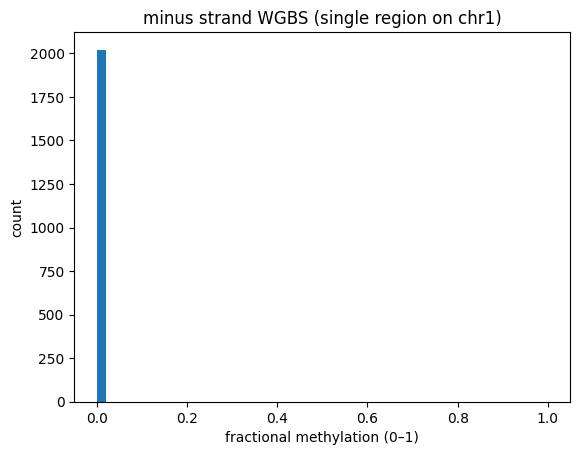

⏳ collecting genome-wide CpG sample ...
✅ collected 61422 CpGs across genome
   min=0.000  max=100.000  mean=4.696
   pct_unmethylated(<0.2)=94.26%  pct_methylated(>0.8)=5.74%


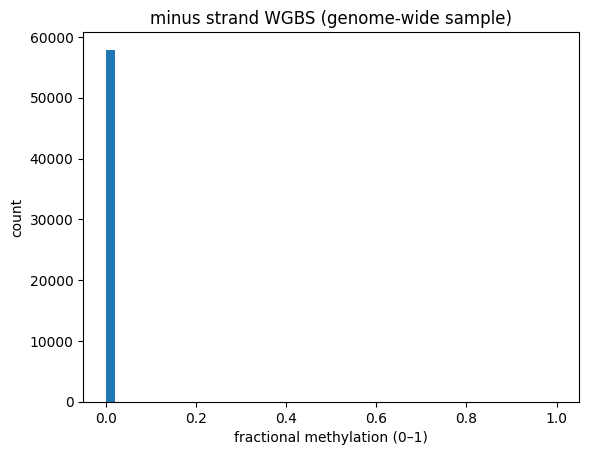


=== plus strand ===
chromosomes (canon): ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16'] ...  (n=24)
total bp (canon): 3,088,269,832
⏳ sampling chr1 until CpGs are found ...
✅ found 28114 CpGs in region chr1:16,939,562-17,139,562
   min=0.000  max=100.000  mean=6.993


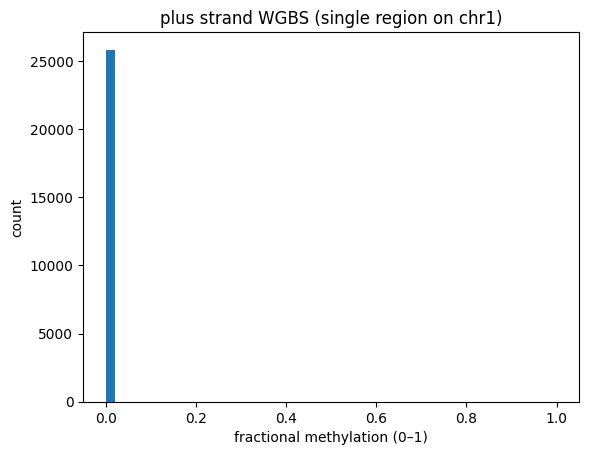

⏳ collecting genome-wide CpG sample ...
✅ collected 68833 CpGs across genome
   min=0.000  max=100.000  mean=4.536
   pct_unmethylated(<0.2)=94.24%  pct_methylated(>0.8)=5.76%


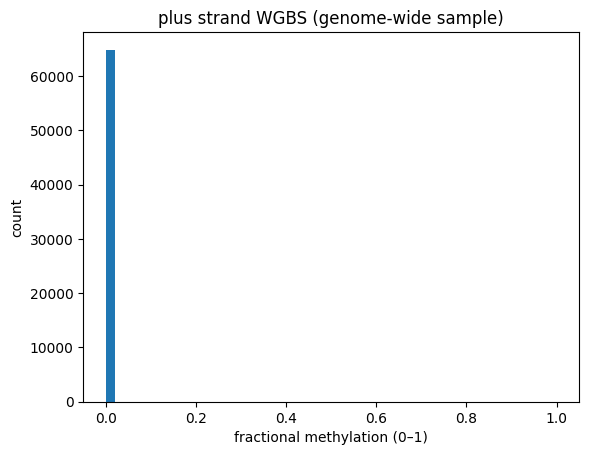

In [ ]:
# --- Level 0 EDA for WGBS bigWigs (robust, with prints) ---

import pyBigWig, numpy as np, random
import matplotlib.pyplot as plt

MINUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-minusstrand-ENCFF031EOZ.bigWig"
PLUS_PATH  = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-plusstrand-ENCFF047NJL.bigWig"

bw_minus = pyBigWig.open(MINUS_PATH)
bw_plus  = pyBigWig.open(PLUS_PATH)

CANON = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY"]
WINDOW = 200_000       # bp; bigger window increases chance of CpGs
RETRIES = 400          # tries per sampling attempt
TARGET_CPGS = 50_000   # for genome sample hist

def quick_info(label, bw):
    chroms = bw.chroms()
    canon = {c:L for c,L in chroms.items() if c in CANON}
    print(f"\n=== {label} strand ===")
    print(f"chromosomes (canon): {list(canon.keys())[:8]} ...  (n={len(canon)})")
    print(f"total bp (canon): {sum(canon.values()):,}")

def sample_window_with_cpgs(bw, chrom="chr1", window=WINDOW, retries=RETRIES):
    """Randomly sample windows until we find CpGs (non-NaN values)."""
    L = bw.chroms()[chrom]
    for _ in range(retries):
        start = random.randint(0, max(1, L-window))
        end = start + window
        vals = bw.values(chrom, start, end, numpy=True)
        if vals is None:
            continue
        vals = np.array(vals)
        clean = vals[~np.isnan(vals)]
        if clean.size > 0:
            return clean, (chrom, start, end)
    return np.array([]), None

def collect_genome_sample(bw, per_chrom=10, window=WINDOW, target=TARGET_CPGS):
    """Aggregate CpGs from many random windows across chromosomes until target count."""
    pieces, total = [], 0
    for chrom, L in bw.chroms().items():
        if chrom not in CANON or L < window:
            continue
        for _ in range(per_chrom):
            start = random.randint(0, max(1, L-window))
            end = start + window
            vals = bw.values(chrom, start, end, numpy=True)
            if vals is None:
                continue
            vals = np.array(vals)
            clean = vals[~np.isnan(vals)]
            if clean.size:
                pieces.append(clean)
                total += clean.size
                if total >= target:
                    return np.concatenate(pieces)
    return np.concatenate(pieces) if pieces else np.array([])

def level0_for_track(label, bw):
    quick_info(label, bw)

    # 1) Single-chrom quick sample (chr1), auto-retry so it never comes back empty
    print("⏳ sampling chr1 until CpGs are found ...")
    clean, region = sample_window_with_cpgs(bw, chrom="chr1")
    if clean.size == 0:
        print("⚠️  could not find CpGs on chr1 with current settings; trying genome-wide sample.")
    else:
        print(f"✅ found {clean.size} CpGs in region {region[0]}:{region[1]:,}-{region[2]:,}")
        print(f"   min={clean.min():.3f}  max={clean.max():.3f}  mean={clean.mean():.3f}")
        plt.hist(clean, bins=50, range=(0,1))
        plt.title(f"{label} strand WGBS (single region on chr1)")
        plt.xlabel("fractional methylation (0–1)"); plt.ylabel("count")
        plt.show()

    # 2) Genome-wide sample (guaranteed overview)
    print("⏳ collecting genome-wide CpG sample ...")
    genome_clean = collect_genome_sample(bw, target=TARGET_CPGS)
    if genome_clean.size == 0:
        print("❌ no CpGs collected; increase WINDOW or check file path/format.")
        return
    print(f"✅ collected {genome_clean.size} CpGs across genome")
    print(f"   min={genome_clean.min():.3f}  max={genome_clean.max():.3f}  mean={genome_clean.mean():.3f}")
    print(f"   pct_unmethylated(<0.2)={np.mean(genome_clean<0.2):.2%}  "
          f"pct_methylated(>0.8)={np.mean(genome_clean>0.8):.2%}")

    plt.hist(genome_clean, bins=50, range=(0,1))
    plt.title(f"{label} strand WGBS (genome-wide sample)")
    plt.xlabel("fractional methylation (0–1)"); plt.ylabel("count")
    plt.show()

# --- run Level 0 for both strands ---
level0_for_track("minus", bw_minus)
level0_for_track("plus",  bw_plus)




# What this cell does (one-liner)

It bins the genome (default 1 kb) and computes the CpG-only mean methylation per bin for the minus and plus strand bigWig tracks, then merges them and adds a strand-combined methylation value. It prints progress/QC and saves the result to CSV.

# Inputs & assumptions

- MINUS_PATH, PLUS_PATH: WGBS bigWigs containing fractional methylation values (0–1) only at CpG positions; non-CpG bases are NaN.

- BIN = 1_000: bin size in bp; smaller = finer resolution & slower, larger (e.g., 5–10 kb) = faster, smoother.

- CANON: chromosomes to include (autosomes + chrX/chrY).

- Output path OUT_CSV.

# How it works step-by-step

1. **Open bigWigs**

```
bw_minus = pyBigWig.open(MINUS_PATH)
bw_plus  = pyBigWig.open(PLUS_PATH) is formatted as code
```
Gives random access to methylation values along the genome.

2. **Binning function**(binner)

- Iterates over the selected chromosomes (CANON) and tiles each into BIN-sized windows.

- For each bin: bw.values(chrom, start, end, numpy=True), drops NaNs (non-CpG positions), and computes the mean of the remaining values.

  - If a bin contains no CpGs, the mean is set to NaN (important to distinguish “no data” from “fully unmethylated”).

- Prints progress (estimated total bins, running rate) so you can see it’s moving.

- Returns a tidy DataFrame with columns: chrom, start, end, <label>_mean.

3. **Run for both strands**
```
df_minus = binner(bw_minus, "meth_minus", ...)
df_plus  = binner(bw_plus,  "meth_plus", ...)
```


4. **Merge minus & plus**

- Inner-joins on the genomic bin coordinates to line up the two strand summaries.

5. **Create a strand-combined column**
```
df_meth["meth_combined_mean"] = df_meth[["meth_minus_mean","meth_plus_mean"]].mean(axis=1, skipna=True)
```
- This is the average of any available strands (ignoring NaNs).

- If both strands are NaN (no CpGs in the bin), combined stays NaN.

6. **QC coverage & save**

- Prints the fraction of bins with at least one CpG on each strand and on either strand.

- Writes the full table to CSV and prints a preview.

# Why these choices are sensible

- **CpG-only mean**: WGBS signal is sparse; averaging only called CpGs prevents diluting with NaNs and keeps “no CpGs” distinct from “zero methylation”.

- **Keep NaNs**: lets you evaluate coverage and avoid bias from CpG deserts.

- **Strand-combined**: WGBS methylation is symmetric at CpGs; combining increases coverage per bin.

- **Progress prints**: large genomes + 1 kb bins can take a while; prints reassure you it’s working.

# What the output means

Each row is a genomic window with:

- meth_minus_mean, meth_plus_mean: mean fractional methylation for CpGs observed in that bin on each strand.

- meth_combined_mean: mean across whatever strands had CpGs in that bin (best single value to use downstream).

- Coverage stats tell you how many bins actually contained CpGs—useful when choosing bin size.

# Common pitfalls it avoids

- Confusing no CpGs with unmethylated: uses NaN for the former.

- Mixing chromosomes you don’t want: filters to CANON.

- Silent failures: progress counters & timing.

# Knobs you can tune

- **Speed vs resolution**: set BIN = 5_000 or 10_000 for faster runs and to match 10 kb Hi-C.

- **Genome subset**: restrict CANON (e.g., autosomes only) to speed up.

- **Statistic**: swap np.mean for np.median (robust to outliers) or compute additional metrics (e.g., %CpGs >0.8).

In [ ]:
# --- Level 1 processing for WGBS bigWigs (with progress prints) ---

import pyBigWig, numpy as np, pandas as pd, math, time, os

MINUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-minusstrand-ENCFF031EOZ.bigWig"
PLUS_PATH  = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-plusstrand-ENCFF047NJL.bigWig"

BIN = 1_000  # 1 kb windows; change to 5_000 or 10_000 to speed up
CANON = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY"]  # canonical chromosomes to include
OUT_CSV = "/content/drive/MyDrive/WGBS_level1_1kb.csv"      # output path

bw_minus = pyBigWig.open(MINUS_PATH)
bw_plus  = pyBigWig.open(PLUS_PATH)

def binner(bw, label, bin_bp=BIN, canon=CANON, print_every_bins=200_000):
    """
    Return a dataframe with columns:
      chrom, start, end, <label>_mean
    where the mean is the *CpG-only* mean (NaN if no CpGs in the bin).
    """
    rows = []
    total_bins = 0
    print(f"\n=== Binning {label} strand at {bin_bp:,} bp ===")

    # choose chromosomes to process
    chroms = {c:L for c, L in bw.chroms().items() if c in canon and L >= 1}
    order = [c for c in canon if c in chroms]  # keep canonical order

    for chrom in order:
        L = chroms[chrom]
        nbins = math.ceil(L / bin_bp)
        total_bins += nbins
    print(f"Chromosomes: {order}")
    print(f"Estimated total bins: {total_bins:,}")

    start_time = time.time()
    bins_done = 0

    for chrom in order:
        L = chroms[chrom]
        nbins = math.ceil(L / bin_bp)
        print(f"  ⏳ {label}: {chrom} length={L:,} bp → {nbins:,} bins")

        for b in range(nbins):
            start = b * bin_bp
            end = min(start + bin_bp, L)

            vals = bw.values(chrom, start, end, numpy=True)
            if vals is None:
                mean = np.nan
            else:
                vals = np.array(vals)
                vals = vals[~np.isnan(vals)]  # keep only CpG calls
                mean = float(np.mean(vals)) if vals.size else np.nan

            rows.append((chrom, start, end, mean))
            bins_done += 1

            if bins_done % print_every_bins == 0:
                elapsed = time.time() - start_time
                rate = bins_done / max(elapsed, 1e-6)
                print(f"    … {bins_done:,}/{total_bins:,} bins ({rate:,.1f} bins/s)")

        print(f"  ✅ {label}: {chrom} done")

    elapsed = time.time() - start_time
    print(f"✅ Finished {label} strand: {bins_done:,} bins in {elapsed:,.1f}s "
          f"({bins_done/max(elapsed,1e-6):,.1f} bins/s)")

    df = pd.DataFrame(rows, columns=["chrom","start","end",f"{label}_mean"])
    return df

# Run binning for both strands
df_minus = binner(bw_minus, "meth_minus", BIN, CANON)
df_plus  = binner(bw_plus,  "meth_plus",  BIN, CANON)

# Merge on genomic bins
print("\n🔗 Merging minus & plus…")
df_meth = df_minus.merge(df_plus, on=["chrom","start","end"], how="inner")

# Combined strand methylation:
#   use the mean of the available strands per bin (skipping NaNs);
#   if both NaN → combined is NaN.
df_meth["meth_combined_mean"] = df_meth[["meth_minus_mean","meth_plus_mean"]].mean(axis=1, skipna=True)

# Quick coverage stats
cov_minus = df_meth["meth_minus_mean"].notna().mean()
cov_plus  = df_meth["meth_plus_mean"].notna().mean()
cov_any   = df_meth["meth_combined_mean"].notna().mean()
print(f"Coverage (fraction of bins with ≥1 CpG): minus={cov_minus:.2%}, plus={cov_plus:.2%}, any={cov_any:.2%}")

# Save to CSV
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df_meth.to_csv(OUT_CSV, index=False)
print(f"💾 Saved Level-1 WGBS bins → {OUT_CSV}")
print(df_meth.head())



=== Binning meth_minus strand at 1,000 bp ===
Chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']
Estimated total bins: 3,088,281
  ⏳ meth_minus: chr1 length=248,956,422 bp → 248,957 bins
    … 200,000/3,088,281 bins (13,735.3 bins/s)
  ✅ meth_minus: chr1 done
  ⏳ meth_minus: chr2 length=242,193,529 bp → 242,194 bins
    … 400,000/3,088,281 bins (13,593.1 bins/s)
  ✅ meth_minus: chr2 done
  ⏳ meth_minus: chr3 length=198,295,559 bp → 198,296 bins
    … 600,000/3,088,281 bins (13,637.2 bins/s)
  ✅ meth_minus: chr3 done
  ⏳ meth_minus: chr4 length=190,214,555 bp → 190,215 bins
    … 800,000/3,088,281 bins (13,661.3 bins/s)
  ✅ meth_minus: chr4 done
  ⏳ meth_minus: chr5 length=181,538,259 bp → 181,539 bins
    … 1,000,000/3,088,281 bins (13,716.6 bins/s)
  ✅ meth_minus: chr5 done
  ⏳ meth_minus: chr6 length=170,805,979 bp → 

# What this cell does (one-liner)

It computes per-chromosome correlations between DNA methylation and Hi-C contact strength by (a) turning each Hi-C diagonal NPZ into a 1D interaction signal per 10 kb bin, (b) aligning/bucketing your binned WGBS methylation to the same bins, and (c) reporting Pearson and Spearman correlations for every chromosome file it finds.

# Inputs & assumptions
- df_meth: Level-1 WGBS dataframe with columns chrom, start, end, meth_combined_mean (average of minus/plus strand, NaN if a bin has no CpGs).

- HIC_DIR: folder with one .npz per chromosome, each storing Hi-C diagonals as arrays keyed '0','±1','±2',…'.

- Resolution: 10,000 bp bins (hardcoded in the function; matches your Hi-C diag length and Level-1 binning).

- K = 5: sums ±5 diagonals around the main diagonal to get a per-bin Hi-C “interaction strength” (≈ local 100 kb neighborhood).

- Values are log1p-transformed to stabilize heavy tails in Hi-C.

# How it works step-by-step

1. **File loop**
It lists *.npz in HIC_DIR, and for each file infers the chromosome name via regex (chr[0-9XYM]+).

2. **Build Hi-C 1D signal**(build_hic_signal)

- Starts with the main diagonal ('0') and adds the first K upper and lower diagonals (aligning them to the correct bins).

- Applies np.log1p to reduce skew (handles zeros safely).

3. **Align methylation to Hi-C bins** (correlate_one)

- Filters df_meth to that chromosome.

- Computes hic_bin = start // 10_000 to map each methylation bin to the Hi-C grid.

- Averages methylation within each hic_bin.

- Drops any bins beyond the Hi-C length and merges with the Hi-C 1D signal by hic_bin.

4. **Correlate**

- Masks out NaN methylation bins (bins with no CpGs).

- Computes Pearson r (linear) and Spearman ρ (rank/monotonic).

- Returns a per-chrom record: chrom, bins_used, pearson_r, pearson_p, spearman_rho, spearman_p.

5. **Collect results**

- Aggregates all per-chrom results into summary_meth_hic (a tidy dataframe you can save or plot).

# Why the design choices

- **Diagonal summation (±K)**: captures a broader 3D neighborhood per bin (not just self or 10 kb apart), which correlates better with epigenetic state. Larger K = broader context (often stronger association).

- **log1p(Hi-C)**: Hi-C counts are overdispersed; log1p normalizes and prevents large peaks from dominating.

- **Spearman in addition to Pearson**: methylation is often bimodal (near 0 or 1); the relationship with Hi-C is usually monotonic but non-linear, so Spearman is the reliable signal here.

- **NaN handling**: bins with no CpGs are not counted (mask), so results reflect true CpG observations, not empty windows.

# How to interpret the output

- bins_used: the number of bins where methylation was present (≥1 CpG) and aligned to a Hi-C bin. More bins = more confident statistics.

- **Pearson r**: expect weak to modest values (often near 0 for raw methylation) because the relationship is non-linear.

- **Spearman ρ**: expect moderate positive values (~0.3–0.6), indicating that higher Hi-C interaction generally tracks with lower methylation in active regions (the monotonic relation can be positive depending on how you aggregate; flipping methylation to 1 − meth typically strengthens the positive coupling to Hi-C/A-compartment).

- **p-values**: with tens of thousands of bins, they’ll be ~0 even for modest effect sizes; focus on r/ρ magnitudes and consistency across chromosomes.

# Common pitfalls it avoids

- **Resolution mismatch** (maps methylation bins to 10 kb grid).

- **Symmetry handling** in diagonals (adds both +d and −d).

- **Zero/NaN issues** (log1p for Hi-C; NaN mask for methylation).

# Easy tweaks

- **Change context size**: try K = 1, 2, 10, 20 to see how neighborhood scale affects correlation.

- **Different methylation summary**: replace meth_combined_mean with strand-specific columns or a robust statistic (median).

- **Flip methylation**: correlate 1 - meth_combined_mean with Hi-C; Pearson should become more negative (or Spearman change as expected), clarifying the inverse relation to openness.

- **Match to ATAC bins**: if you want direct 3-way comparisons, ensure all tracks use the same bin size (10 kb in your Hi-C).


In [ ]:
import glob, re, os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# --- inputs ---
METH_DF = df_meth     # from Level-1 methylation
HIC_DIR = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/hic_matrix"
METH_COL = "meth_combined_mean"   # use combined strand mean
K = 5                              # ± diagonals to sum into Hi-C signal
DO_SCATTER = False                 # set True to plot
# ----------------


def build_hic_signal(f, K):
    N = f['0'].shape[0]
    sig = np.zeros(N, float)
    sig += f['0']
    for d in range(1, K+1):
        if str(d) in f.files:      sig[:N-d] += f[str(d)]
        if f"-{d}" in f.files:     sig[d:]   += f[f"-{d}"]
    return np.log1p(sig)


def correlate_one(npz_path, df_meth, meth_col, K, hic_bin_bp=10_000, scatter=False):
    chrom = re.search(r"(chr[0-9XYM]+)", npz_path).group(1)

    f = np.load(npz_path)
    N = f['0'].shape[0]
    hic_signal = build_hic_signal(f, K)

    # restrict methylation df to this chromosome
    sub = df_meth[df_meth["chrom"] == chrom].copy()
    if sub.empty:
        raise ValueError(f"No methylation bins for {chrom}")

    sub["hic_bin"] = (sub["start"] // hic_bin_bp).astype(int)
    meth_binned = (
        sub.groupby("hic_bin", as_index=False)[meth_col]
           .mean()
           .rename(columns={meth_col: "meth_signal"})
    )
    meth_binned = meth_binned[meth_binned["hic_bin"] < N]

    hic_df = pd.DataFrame({"hic_bin": np.arange(N), "hic_signal": hic_signal})
    merged = meth_binned.merge(hic_df, on="hic_bin", how="inner").sort_values("hic_bin")

    x = merged["meth_signal"].to_numpy()
    y = merged["hic_signal"].to_numpy()
    mask = ~np.isnan(x)

    pear = pearsonr(x[mask], y[mask])
    spear = spearmanr(x[mask], y[mask])

    if scatter:
        import matplotlib.pyplot as plt
        plt.scatter(x[mask], y[mask], s=3, alpha=0.3)
        plt.xlabel(f"{meth_col} per {hic_bin_bp//1000} kb bin")
        plt.ylabel(f"Hi-C signal (log1p, ±{K})")
        plt.title(f"{chrom}: r={pear.statistic:.2f}, ρ={spear.correlation:.2f}")
        plt.show()

    return {
        "chrom": chrom,
        "bins_used": mask.sum(),
        "pearson_r": pear.statistic,
        "pearson_p": pear.pvalue,
        "spearman_rho": spear.correlation,
        "spearman_p": spear.pvalue
    }


# --- loop across all Hi-C files ---
results = []
files = sorted(glob.glob(os.path.join(HIC_DIR, "*.npz")))
print(f"Found {len(files)} Hi-C files\n")

for i, path in enumerate(files, 1):
    print(f"[{i}/{len(files)}] {os.path.basename(path)}")
    try:
        out = correlate_one(path, METH_DF, METH_COL, K)
        print(f"  → {out['chrom']}: r={out['pearson_r']:.3f}, ρ={out['spearman_rho']:.3f}")
        results.append(out)
    except Exception as e:
        print(f"  ⚠️ skipped: {e}")

summary_meth_hic = pd.DataFrame(results).sort_values("chrom")
summary_meth_hic


In [ ]:
!pip install pyBigWig
import pyBigWig

# open the file
bw = pyBigWig.open("/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw")

# see available chromosomes and their lengths
print(bw.chroms())

# get summary stats
print("Mean signal:", bw.stats("chr1", 0, bw.chroms()["chr1"], type="mean"))

# fetch signal over a region (in bp coordinates)
values = bw.values("chr1", 100000, 101000)
print(values[:10])  # first 10 values


In [ ]:
!pip install pybigwig torch pandas numpy

In [ ]:
# One-row-per-chromosome epigenomic embeddings
# Inputs in EPI_DIR:
#   atac.bw
#   ctcf_log2fc.bw
#   dnameth-plusstrand-*.bw
#   dnameth-minusstrand-*.bw
#
# pip install pybigwig torch pandas numpy

from pathlib import Path
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import pyBigWig as pybigwig


# ---------- USER CONFIG ----------
EPI_DIR = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features"   # <- change
OUT_CSV = None                              # default: save next to bigWigs
N_SAMPLES_PER_CHR = 1_048_576               # total samples along a chromosome (per track)
COMBINE_METH_STRANDS = False                # True → average +/− into one “METH” channel
CHROM_INCLUDE = None                        # e.g. ["chr1","chr2"]; None = all autosomes + chrX/Y if present
BATCH_POSITIONS = 8192                      # positions per forward pass (RAM control)
# -----------------------------------

# ----- model: untrained C.Origami-style epigenomic 1D encoder -----
class ResidualBlock1D(nn.Module):
    def __init__(self, c, k=5):
        super().__init__()
        p = k//2
        self.c1 = nn.Conv1d(c, c, k, padding=p)
        self.b1 = nn.BatchNorm1d(c)
        self.c2 = nn.Conv1d(c, c, k, padding=p)
        self.b2 = nn.BatchNorm1d(c)
    def forward(self, x):
        y = F.relu(self.b1(self.c1(x)), inplace=True)
        y = self.b2(self.c2(y))
        return F.relu(x + y, inplace=True)

class ScalingBlock1D(nn.Module):
    def __init__(self, c_in, c_out, k=5, s=2):
        super().__init__()
        p = k//2
        self.c = nn.Conv1d(c_in, c_out, k, stride=s, padding=p)
        self.b = nn.BatchNorm1d(c_out)
    def forward(self, x): return F.relu(self.b(self.c(x)), inplace=True)

class EpiEncoder(nn.Module):
    # input: (B, K, Lchunk)  → output per chunk: (B, 2*C_last)
    def __init__(self, k_channels, schedule=(32,32,32,32,64,64,128,128,128,128,256,256), ksize=5):
        super().__init__()
        self.header = nn.Sequential(
            nn.Conv1d(k_channels, schedule[0], ksize, stride=2, padding=ksize//2),
            nn.BatchNorm1d(schedule[0]), nn.ReLU(inplace=True)
        )
        blocks, c = [], schedule[0]
        for c_out in schedule:
            blocks += [ResidualBlock1D(c, ksize), ScalingBlock1D(c, c_out, ksize, s=2)]
            c = c_out
        self.body = nn.Sequential(*blocks)
        self.out_c = c
    def forward(self, x):
        x = self.header(x)
        z = self.body(x)            # (B, C, L')
        # chunk-level pooling
        return torch.cat([z.mean(-1), z.max(-1).values], dim=1)

# ----- bigWig utilities -----
def open_tracks(epi_dir: Path):
    def pick(patterns):
        for p in patterns:
            hits = list(epi_dir.glob(p))
            if hits: return hits[0]
        return None

    bw_atac = pick(["atac*.bw"])
    bw_ctcf = pick(["*ctcf*log2fc*.bw", "ctcf*.bw"])
    bw_mplus  = pick(["*meth*plus*strand*.bw","*plus*strand*.bw","*meth*pos*.bw"])
    bw_mminus = pick(["*meth*minus*strand*.bw","*minus*strand*.bw","*meth*neg*.bw"])

    tracks = {}
    if bw_ctcf: tracks["CTCF_LOG2FC"] = pybigwig.open(str(bw_ctcf))
    if bw_atac: tracks["ATAC"]        = pybigwig.open(str(bw_atac))
    if bw_mplus:  tracks["METH_PLUS"]  = pybigwig.open(str(bw_mplus))
    if bw_mminus: tracks["METH_MINUS"] = pybigwig.open(str(bw_mminus))
    if not tracks: raise RuntimeError("No bigWigs found in EPI_DIR.")

    # determine chromosomes & lengths from the first track
    first = next(iter(tracks.values()))
    chroms = dict(first.chroms())  # {chr: length}
    return tracks, chroms

def bw_stats(bw, chrom, start, end, n_bins, typ="mean"):
    vals = bw.stats(chrom, int(start), int(end), nBins=int(n_bins), type=typ)
    return np.array([0.0 if v is None else float(v) for v in vals], dtype=np.float32)

def transform_track(vec, kind):
    if kind in ("counts","ctcf"):
        return np.log1p(np.clip(vec, 0.0, None)).astype(np.float32)
    if kind == "methyl":
        v = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
        if np.nanmax(v) > 1.5: v = v/100.0
        return np.clip(v, 0.0, 1.0).astype(np.float32)
    return vec.astype(np.float32)

# ----- main pipeline -----
def main():
    epi_dir = Path(EPI_DIR)
    tracks, chroms = open_tracks(epi_dir)

    # choose channels & order
    channels = []
    if "CTCF_LOG2FC" in tracks: channels.append(("CTCF_LOG2FC","ctcf"))
    if "ATAC" in tracks:        channels.append(("ATAC","counts"))
    if COMBINE_METH_STRANDS and ("METH_PLUS" in tracks or "METH_MINUS" in tracks):
        channels.append(("METH","methyl"))
    else:
        if "METH_PLUS"  in tracks: channels.append(("METH_PLUS","methyl"))
        if "METH_MINUS" in tracks: channels.append(("METH_MINUS","methyl"))

    model = EpiEncoder(k_channels=len(channels)).eval()
    device = torch.device("cpu")
    model.to(device)

    # choose chromosomes
    chr_list = sorted(chroms.keys(), key=lambda c: (len(c), c))
    if CHROM_INCLUDE:
        chr_list = [c for c in chr_list if c in CHROM_INCLUDE]
    # simple default: autosomes + X/Y if present
    if CHROM_INCLUDE is None:
        chr_list = [c for c in chr_list if c.startswith("chr")]

    rows = []
    for chrom in chr_list:
        L = chroms[chrom]
        # number of points to sample along chromosome
        n = int(min(N_SAMPLES_PER_CHR, max(1024, 2**int(np.floor(np.log2(L/100))))))  # make it reasonable
        # build per-track arrays
        track_arrays = []
        # pre-sample methyl strands if combining
        if any(nm=="METH" for nm,_ in channels):
            plus = bw_stats(tracks.get("METH_PLUS"), chrom, 0, L, n) if "METH_PLUS" in tracks else np.zeros(n, np.float32)
            minus= bw_stats(tracks.get("METH_MINUS"),chrom, 0, L, n) if "METH_MINUS" in tracks else np.zeros(n, np.float32)
            meth = (plus + minus)/2.0
        for name, kind in channels:
            if name == "METH":
                vec = meth
            else:
                vec = bw_stats(tracks[name], chrom, 0, L, n)
            track_arrays.append(transform_track(vec, kind))

        # chunked forward passes to control RAM
        X = np.stack(track_arrays, axis=0)  # (K, n)
        pos = 0
        agg_sum = None; agg_count = 0
        while pos < n:
            sl = slice(pos, min(pos+BATCH_POSITIONS, n))
            x = torch.from_numpy(X[:, sl][None, ...]).float().to(device)  # (1,K,Lchunk)
            with torch.no_grad():
                z = model(x)        # (1, D)
            vec = z.squeeze(0).cpu().numpy()
            if agg_sum is None: agg_sum = vec.copy()
            else: agg_sum += vec
            agg_count += 1
            pos = sl.stop
        chr_vec = agg_sum / max(agg_count, 1)

        rows.append((chrom, *chr_vec.tolist()))

    # make dataframe
    D = len(rows[0]) - 1 if rows else 0
    cols = ["chrom"] + [f"epi_embed_{i:04d}" for i in range(D)]
    df = pd.DataFrame(rows, columns=cols).set_index("chrom")
    out = OUT_CSV or str(epi_dir / f"epi_chr_embeddings_{'-'.join([c for c,_ in channels])}.csv")
    df.to_csv(out)
    print("Saved:", out, "shape:", df.shape)
    print(df.head())

if __name__ == "__main__":
    main()


In [ ]:
from pathlib import Path
from google.colab import drive
import os

drive.mount('/content/drive')

EPI_DIR = Path("/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features")  # <— set this correctly
print("EPI_DIR exists:", EPI_DIR.exists(), "is_dir:", EPI_DIR.is_dir())
print("Top-level files:")
for p in sorted(EPI_DIR.iterdir()):
    print(" -", p.name)


In [ ]:
# =============================================================================
# PCA Analysis Cell for ATAC-seq, DNA Methylation, and CTCF Data
# =============================================================================
# This cell performs PCA on integrated epigenomic features (ATAC-seq, DNA
# methylation, and CTCF) across genomic bins. It creates visualizations showing
# how different chromosomes cluster in epigenomic space.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyBigWig

# ---------- CONFIGURATION ----------
ATAC_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw"
CTCF_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw"
METH_PLUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-plusstrand-ENCFF047NJL.bigWig"
METH_MINUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-minusstrand-ENCFF031EOZ.bigWig"

BIN_SIZE = 10_000  # 10kb bins
N_BINS_PER_CHR = 500  # sample 500 bins per chromosome for PCA
N_COMPONENTS = 3  # number of principal components to compute
CANONICAL_CHROMS = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
# -----------------------------------

print("=" * 70)
print("PCA ANALYSIS: ATAC-seq, DNA Methylation, and CTCF")
print("=" * 70)

# Step 1: Open bigWig files
print("\n[1/6] Opening bigWig files...")
try:
    bw_atac = pyBigWig.open(ATAC_PATH)
    print(f"  ✓ ATAC-seq loaded: {ATAC_PATH}")
except:
    print(f"  ✗ Failed to load ATAC-seq")
    bw_atac = None

try:
    bw_ctcf = pyBigWig.open(CTCF_PATH)
    print(f"  ✓ CTCF loaded: {CTCF_PATH}")
except:
    print(f"  ✗ Failed to load CTCF")
    bw_ctcf = None

try:
    # You may need to update these paths with the exact filenames
    import glob
    meth_plus_files = glob.glob(METH_PLUS_PATH)
    meth_minus_files = glob.glob(METH_MINUS_PATH)
    if meth_plus_files:
        bw_meth_plus = pyBigWig.open(meth_plus_files[0])
        print(f"  ✓ DNA Methylation (plus) loaded: {meth_plus_files[0]}")
    else:
        bw_meth_plus = None
        print(f"  ✗ No methylation plus strand file found")

    if meth_minus_files:
        bw_meth_minus = pyBigWig.open(meth_minus_files[0])
        print(f"  ✓ DNA Methylation (minus) loaded: {meth_minus_files[0]}")
    else:
        bw_meth_minus = None
        print(f"  ✗ No methylation minus strand file found")
except Exception as e:
    print(f"  ✗ Failed to load methylation data: {e}")
    bw_meth_plus = None
    bw_meth_minus = None

# Step 2: Sample genomic bins from each chromosome
print(f"\n[2/6] Sampling {N_BINS_PER_CHR} bins per chromosome (bin size: {BIN_SIZE:,} bp)...")

def sample_bins(bw, chrom, chrom_len, n_bins, bin_size):
    """Sample random bins from a chromosome and compute mean signal"""
    if bw is None:
        return np.full(n_bins, np.nan)

    valid_bins = []
    max_start = max(0, chrom_len - bin_size)
    attempts = 0
    max_attempts = n_bins * 3  # avoid infinite loops

    while len(valid_bins) < n_bins and attempts < max_attempts:
        start = np.random.randint(0, max_start + 1) if max_start > 0 else 0
        end = start + bin_size

        try:
            vals = bw.values(chrom, start, end, numpy=True)
            if vals is not None:
                # Remove NaNs and compute mean
                clean_vals = vals[~np.isnan(vals)]
                if len(clean_vals) > 0:
                    valid_bins.append(np.mean(clean_vals))
                else:
                    valid_bins.append(0.0)
        except:
            valid_bins.append(0.0)

        attempts += 1

    # Pad with zeros if we didn't get enough bins
    while len(valid_bins) < n_bins:
        valid_bins.append(0.0)

    return np.array(valid_bins[:n_bins])

# Get chromosome information from ATAC file (or first available)
ref_bw = bw_atac if bw_atac else (bw_ctcf if bw_ctcf else (bw_meth_plus if bw_meth_plus else bw_meth_minus))
if ref_bw is None:
    raise RuntimeError("No bigWig files could be loaded!")

chrom_dict = ref_bw.chroms()
chroms_to_use = [c for c in CANONICAL_CHROMS if c in chrom_dict and chrom_dict[c] >= BIN_SIZE]

print(f"  Processing {len(chroms_to_use)} chromosomes: {', '.join(chroms_to_use[:5])}{'...' if len(chroms_to_use) > 5 else ''}")

# Collect data
data_rows = []
np.random.seed(42)  # for reproducibility

for chrom in chroms_to_use:
    chrom_len = chrom_dict[chrom]

    # Sample bins for each track
    atac_vals = sample_bins(bw_atac, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    ctcf_vals = sample_bins(bw_ctcf, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    meth_plus_vals = sample_bins(bw_meth_plus, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    meth_minus_vals = sample_bins(bw_meth_minus, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)

    # Average methylation strands
    meth_vals = np.nanmean([meth_plus_vals, meth_minus_vals], axis=0)

    for i in range(N_BINS_PER_CHR):
        data_rows.append({
            'chrom': chrom,
            'bin_idx': i,
            'atac': atac_vals[i],
            'ctcf': ctcf_vals[i],
            'meth': meth_vals[i]
        })

# Create DataFrame
df = pd.DataFrame(data_rows)
print(f"  ✓ Collected {len(df):,} genomic bins")

# Step 3: Transform data
print("\n[3/6] Transforming data...")
df['atac_log1p'] = np.log1p(df['atac'].clip(lower=0))
df['ctcf_log1p'] = np.log1p(df['ctcf'].clip(lower=0))
df['meth_scaled'] = df['meth'].fillna(0).clip(0, 1)  # methylation is already 0-1

print(f"  ATAC range: [{df['atac'].min():.2f}, {df['atac'].max():.2f}] → log1p → [{df['atac_log1p'].min():.2f}, {df['atac_log1p'].max():.2f}]")
print(f"  CTCF range: [{df['ctcf'].min():.2f}, {df['ctcf'].max():.2f}] → log1p → [{df['ctcf_log1p'].min():.2f}, {df['ctcf_log1p'].max():.2f}]")
print(f"  Meth range: [{df['meth'].min():.2f}, {df['meth'].max():.2f}] → clipped → [{df['meth_scaled'].min():.2f}, {df['meth_scaled'].max():.2f}]")

# Step 4: Prepare feature matrix and standardize
print("\n[4/6] Standardizing features...")
feature_cols = ['atac_log1p', 'ctcf_log1p', 'meth_scaled']
X = df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"  Feature matrix shape: {X_scaled.shape}")
print(f"  Mean of scaled features: {X_scaled.mean(axis=0)}")
print(f"  Std of scaled features: {X_scaled.std(axis=0)}")

# Step 5: Perform PCA
print(f"\n[5/6] Computing PCA ({N_COMPONENTS} components)...")
pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)

# Add PCA coordinates to dataframe
for i in range(N_COMPONENTS):
    df[f'PC{i+1}'] = X_pca[:, i]

# Print explained variance
print(f"\n  Explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"    PC{i+1}: {var*100:.2f}%")
print(f"  Cumulative: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Print component loadings
print(f"\n  Component loadings:")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(N_COMPONENTS)],
    index=['ATAC-seq', 'CTCF', 'DNA Meth']
)
print(loadings.round(3))

# Step 6: Visualizations
print("\n[6/6] Creating visualizations...")

# Calculate per-chromosome means for coloring
chrom_means = df.groupby('chrom')[['PC1', 'PC2', 'PC3']].mean().reset_index()
chrom_order = sorted(chroms_to_use, key=lambda x: (len(x), x))
chrom_to_idx = {c: i for i, c in enumerate(chrom_order)}
chrom_means['chrom_idx'] = chrom_means['chrom'].map(chrom_to_idx)

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))

# 1. PC1 vs PC2 scatter (all bins)
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(df['PC1'], df['PC2'],
                     c=df['chrom'].map(chrom_to_idx),
                     cmap='tab20', alpha=0.3, s=5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title('PCA: All Genomic Bins (colored by chromosome)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. PC1 vs PC2 (chromosome means)
ax2 = plt.subplot(2, 3, 2)
scatter2 = ax2.scatter(chrom_means['PC1'], chrom_means['PC2'],
                      c=chrom_means['chrom_idx'], cmap='tab20',
                      s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
for _, row in chrom_means.iterrows():
    ax2.annotate(row['chrom'], (row['PC1'], row['PC2']),
                fontsize=8, ha='center', va='center', fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax2.set_title('PCA: Chromosome Centroids', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

# 3. PC1 vs PC3
ax3 = plt.subplot(2, 3, 3)
scatter3 = ax3.scatter(chrom_means['PC1'], chrom_means['PC3'],
                      c=chrom_means['chrom_idx'], cmap='tab20',
                      s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
for _, row in chrom_means.iterrows():
    ax3.annotate(row['chrom'], (row['PC1'], row['PC3']),
                fontsize=8, ha='center', va='center', fontweight='bold')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)
ax3.set_title('PC1 vs PC3: Chromosome Centroids', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Explained variance
ax4 = plt.subplot(2, 3, 4)
pcs = [f'PC{i+1}' for i in range(N_COMPONENTS)]
ax4.bar(pcs, pca.explained_variance_ratio_ * 100, color='steelblue', alpha=0.7)
ax4.set_ylabel('Explained Variance (%)', fontsize=12)
ax4.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, (pc, var) in enumerate(zip(pcs, pca.explained_variance_ratio_ * 100)):
    ax4.text(i, var + 1, f'{var:.1f}%', ha='center', fontweight='bold')

# 5. Component loadings heatmap
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Loading'}, ax=ax5)
ax5.set_title('PCA Component Loadings', fontsize=14, fontweight='bold')
ax5.set_xlabel('Principal Components', fontsize=12)
ax5.set_ylabel('Features', fontsize=12)

# 6. Distribution of PC1 values by chromosome
ax6 = plt.subplot(2, 3, 6)
chrom_subset = [c for c in chrom_order if c in ['chr1', 'chr2', 'chrX', 'chrY']][:4]
df_subset = df[df['chrom'].isin(chrom_subset)]
for chrom in chrom_subset:
    data = df_subset[df_subset['chrom'] == chrom]['PC1']
    ax6.hist(data, bins=30, alpha=0.5, label=chrom)
ax6.set_xlabel('PC1 Value', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('PC1 Distribution (Selected Chromosomes)', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional: 3D scatter plot if requested
if N_COMPONENTS >= 3:
    from mpl_toolkits.mplot3d import Axes3D

    fig2 = plt.figure(figsize=(14, 10))

    # All bins in 3D
    ax3d = fig2.add_subplot(121, projection='3d')
    scatter_3d = ax3d.scatter(df['PC1'], df['PC2'], df['PC3'],
                             c=df['chrom'].map(chrom_to_idx),
                             cmap='tab20', alpha=0.2, s=3)
    ax3d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
    ax3d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
    ax3d.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
    ax3d.set_title('3D PCA: All Bins', fontsize=12, fontweight='bold')

    # Chromosome centroids in 3D
    ax3d2 = fig2.add_subplot(122, projection='3d')
    scatter_3d2 = ax3d2.scatter(chrom_means['PC1'], chrom_means['PC2'], chrom_means['PC3'],
                               c=chrom_means['chrom_idx'], cmap='tab20',
                               s=300, alpha=0.8, edgecolors='black', linewidth=2)
    for _, row in chrom_means.iterrows():
        ax3d2.text(row['PC1'], row['PC2'], row['PC3'], row['chrom'],
                  fontsize=8, fontweight='bold')
    ax3d2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
    ax3d2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
    ax3d2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
    ax3d2.set_title('3D PCA: Chromosome Centroids', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nDataset: {len(df):,} genomic bins across {len(chroms_to_use)} chromosomes")
print(f"Features: ATAC-seq, CTCF, DNA Methylation")
print(f"Bin size: {BIN_SIZE:,} bp")
print(f"\nPCA Results:")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1 dominates with {pca.explained_variance_ratio_[0]*100:.1f}% of variance")
print(f"\nTop contributing features to PC1:")
pc1_loadings = pd.Series(pca.components_[0], index=['ATAC-seq', 'CTCF', 'DNA Meth']).abs().sort_values(ascending=False)
for feat, load in pc1_loadings.items():
    print(f"  {feat}: {load:.3f}")

# Close bigWig files
if bw_atac: bw_atac.close()
if bw_ctcf: bw_ctcf.close()
if bw_meth_plus: bw_meth_plus.close()
if bw_meth_minus: bw_meth_minus.close()

print("\n✓ PCA analysis complete!")
print("="*70)

In [ ]:
import pyBigWig
import numpy as np
import pandas as pd

bw = pyBigWig.open("/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw")

CANON = [f"chr{i}" for i in range(1,23)] + ["chrX", "chrY"]


# -------------------------
# Level 0: File overview
# -------------------------
print("=== LEVEL 0: File Overview ===")
chroms = {c: l for c,l in bw.chroms().items() if c in CANON}

print("Canonical chromosomes:", list(chroms.keys()))
print("Total canonical bases:", f"{sum(chroms.values()):,}")

# global stats over randomly sampled genome bins
sample_vals = []

for chrom, length in chroms.items():
    n_samples = min(2000, length // 5000)
    positions = np.random.randint(0, length, size=n_samples)

    for pos in positions:
        v = bw.values(chrom, pos, pos+1, numpy=True)
        if v is not None:
            x = v[0]
            if not np.isnan(x):
                sample_vals.append(x)

sample_vals = np.array(sample_vals)

print(f"Sampled {len(sample_vals)} signal values")
print("min =", float(np.min(sample_vals)))
print("max =", float(np.max(sample_vals)))
print("mean =", float(np.mean(sample_vals)))
print("pct zero =", float(np.mean(sample_vals == 0) * 100))


# -------------------------
# Level 1: 1kb genomic bins
# -------------------------
print("\n=== LEVEL 1: 1kb Binned Statistics ===")

BIN = 1000
rows = []

for chrom, length in chroms.items():
    n_bins = length // BIN
    means = []
    maxes = []
    for i in range(n_bins):
        start = i * BIN
        end = start + BIN
        vals = bw.values(chrom, start, end, numpy=True)

        if vals is None:
            continue

        vals = vals[~np.isnan(vals)]
        if len(vals) == 0:
            means.append(0.)
            maxes.append(0.)
        else:
            means.append(np.mean(vals))
            maxes.append(np.max(vals))

    rows.append({
        "chrom": chrom,
        "n_bins": len(means),
        "mean_signal": float(np.mean(means)),
        "max_signal": float(np.max(maxes)),
        "pct_nonzero": float(np.mean(np.array(means) > 0) * 100)
    })
    print(f"{chrom}: bins={len(means)}, mean={np.mean(means):.3f}, max={np.max(maxes):.2f}")


df = pd.DataFrame(rows)
df


=== LEVEL 0: File Overview ===
Canonical chromosomes: ['chr13', 'chr12', 'chr11', 'chr10', 'chr17', 'chr16', 'chr15', 'chr19', 'chr18', 'chr14', 'chrX', 'chr4', 'chr2', 'chrY', 'chr8', 'chr22', 'chr20', 'chr7', 'chr6', 'chr5', 'chr3', 'chr1', 'chr21', 'chr9']
Total canonical bases: 3,088,269,832
Sampled 45817 signal values
min = -7.6152801513671875
max = 10.734199523925781
mean = -0.3090283274650574
pct zero = 42.370735753104746

=== LEVEL 1: 1kb Binned Statistics ===
chr13: bins=114364, mean=-0.332, max=11.24
chr12: bins=133275, mean=-0.343, max=11.33
chr11: bins=135086, mean=-0.330, max=11.50
chr10: bins=133797, mean=-0.341, max=11.49
chr17: bins=83257, mean=-0.241, max=11.49
chr16: bins=90338, mean=-0.242, max=11.57
chr15: bins=101991, mean=-0.257, max=11.41
chr19: bins=58617, mean=-0.195, max=11.47
chr18: bins=80373, mean=-0.357, max=11.13
chr14: bins=107043, mean=-0.287, max=11.66
chrX: bins=156040, mean=-0.351, max=11.25
chr4: bins=190214, mean=-0.386, max=11.28
chr2: bins=242193

,chrom,n_bins,mean_signal,max_signal,pct_nonzero
0,chr13,114364,-0.332433,11.24380,27.666049
1,chr12,133275,-0.343025,11.32760,33.328831
2,chr11,135086,-0.329904,11.49730,33.318775
3,chr10,133797,-0.341485,11.48850,33.210012
4,chr17,83257,-0.240844,11.49100,35.048104
5,chr16,90338,-0.241580,11.57290,30.701366
6,chr15,101991,-0.256820,11.41290,26.988656
7,chr19,58617,-0.194545,11.47340,37.038743
8,chr18,80373,-0.356856,11.12780,30.831249
9,chr14,107043,-0.287261,11.66030,27.745859


PCA ANALYSIS: ATAC-seq, DNA Methylation, and CTCF

[1/6] Opening bigWig files...
  ✓ ATAC-seq loaded: /content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw
  ✓ CTCF loaded: /content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw
  ✗ No methylation plus strand file found
  ✗ No methylation minus strand file found

[2/6] Sampling 500 bins per chromosome (bin size: 10,000 bp)...
  Processing 24 chromosomes: chr1, chr2, chr3, chr4, chr5...


/tmp/ipython-input-3816486647.py:126: RuntimeWarning: Mean of empty slice
  meth_vals = np.nanmean([meth_plus_vals, meth_minus_vals], axis=0)


  ✓ Collected 12,000 genomic bins

[3/6] Transforming data...
  ATAC range: [0.00, 1226.40] → log1p → [0.00, 7.11]
  CTCF range: [-1.63, 1.77] → log1p → [0.00, 1.02]
  Meth range: [nan, nan] → clipped → [0.00, 0.00]

[4/6] Standardizing features...
  Feature matrix shape: (12000, 3)

[5/6] Computing PCA (3 components)...

  Explained variance ratio:
    PC1: 51.68%
    PC2: 48.32%
    PC3: 0.00%
  Cumulative: 100.00%

  Component loadings:
            PC1    PC2  PC3
ATAC-seq  0.707  0.707  0.0
CTCF      0.707 -0.707  0.0
DNA Meth  0.000 -0.000  1.0

[6/6] Creating visualizations...


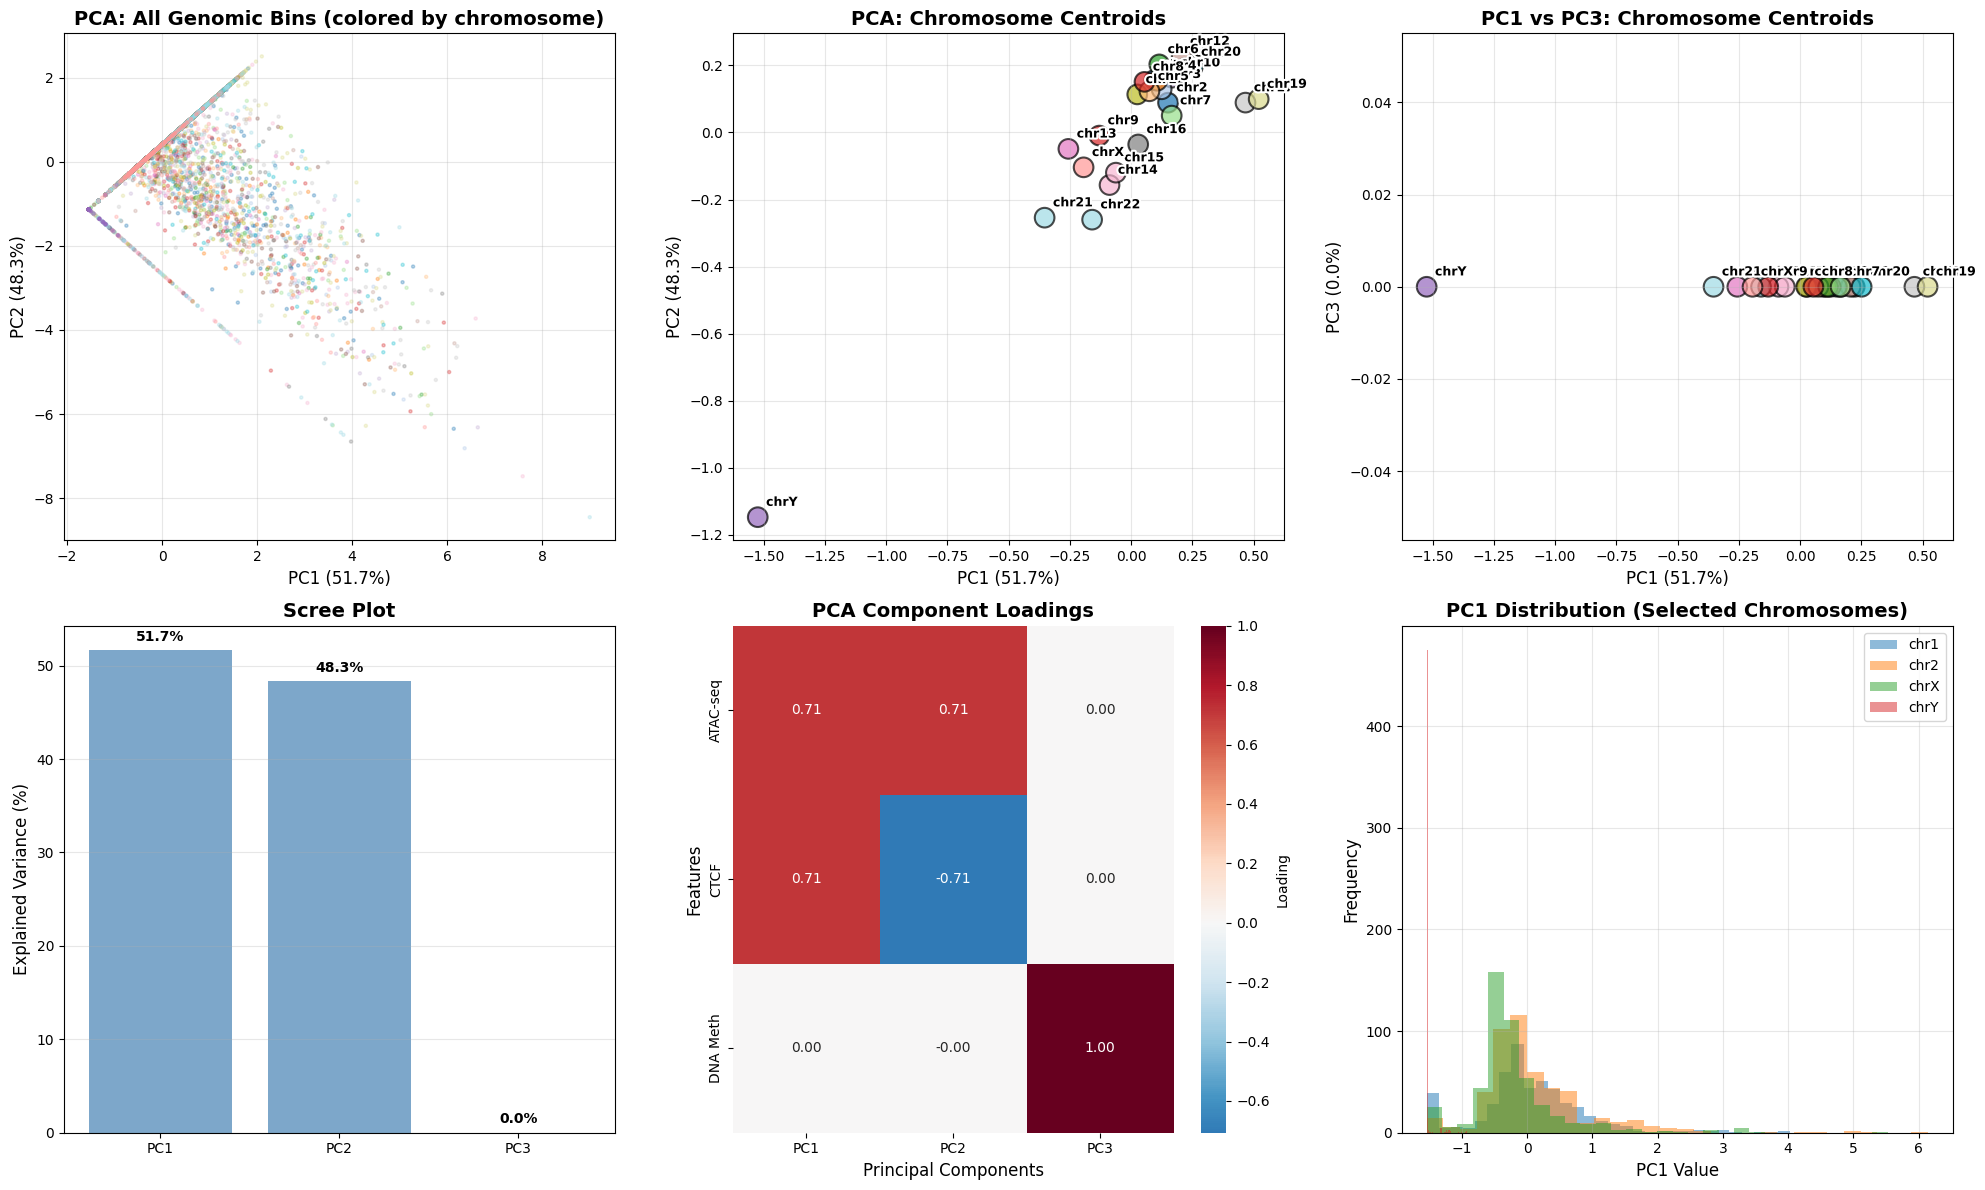

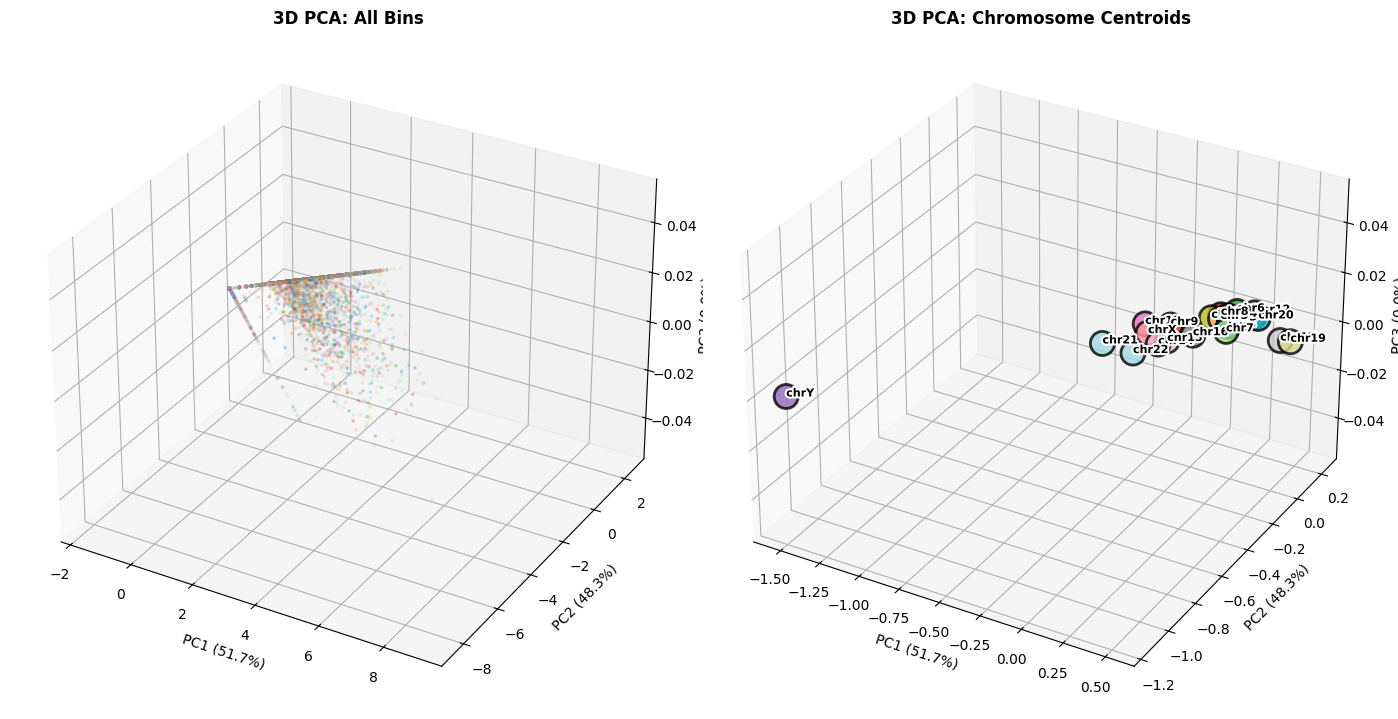


SUMMARY STATISTICS

Dataset: 12,000 genomic bins across 24 chromosomes
Features: ATAC-seq, CTCF, DNA Methylation
Bin size: 10,000 bp

PCA Results:
  Total variance explained: 100.00%
  PC1 dominates with 51.7% of variance

Top contributing features to PC1:
  CTCF: 0.707
  ATAC-seq: 0.707
  DNA Meth: 0.000

✓ PCA analysis complete!


In [5]:
# =============================================================================
# PCA Analysis Cell for ATAC-seq, DNA Methylation, and CTCF Data
# (Option 1: more legible chromosome labels via offsets + white outline)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyBigWig

# NEW: for outlined text labels
import matplotlib.patheffects as pe

# ---------- CONFIGURATION ----------
ATAC_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw"
CTCF_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw"
METH_PLUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-plusstrand-ENCFF047NJL.bigWig"
METH_MINUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-minusstrand-ENCFF031EOZ.bigWig"

BIN_SIZE = 10_000
N_BINS_PER_CHR = 500
N_COMPONENTS = 3
CANONICAL_CHROMS = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
# -----------------------------------

print("=" * 70)
print("PCA ANALYSIS: ATAC-seq, DNA Methylation, and CTCF")
print("=" * 70)

# Step 1: Open bigWig files
print("\n[1/6] Opening bigWig files...")
try:
    bw_atac = pyBigWig.open(ATAC_PATH)
    print(f"  ✓ ATAC-seq loaded: {ATAC_PATH}")
except Exception as e:
    print(f"  ✗ Failed to load ATAC-seq: {e}")
    bw_atac = None

try:
    bw_ctcf = pyBigWig.open(CTCF_PATH)
    print(f"  ✓ CTCF loaded: {CTCF_PATH}")
except Exception as e:
    print(f"  ✗ Failed to load CTCF: {e}")
    bw_ctcf = None

try:
    import glob
    meth_plus_files = glob.glob(METH_PLUS_PATH)
    meth_minus_files = glob.glob(METH_MINUS_PATH)

    if meth_plus_files:
        bw_meth_plus = pyBigWig.open(meth_plus_files[0])
        print(f"  ✓ DNA Methylation (plus) loaded: {meth_plus_files[0]}")
    else:
        bw_meth_plus = None
        print("  ✗ No methylation plus strand file found")

    if meth_minus_files:
        bw_meth_minus = pyBigWig.open(meth_minus_files[0])
        print(f"  ✓ DNA Methylation (minus) loaded: {meth_minus_files[0]}")
    else:
        bw_meth_minus = None
        print("  ✗ No methylation minus strand file found")
except Exception as e:
    print(f"  ✗ Failed to load methylation data: {e}")
    bw_meth_plus = None
    bw_meth_minus = None

# Step 2: Sample genomic bins from each chromosome
print(f"\n[2/6] Sampling {N_BINS_PER_CHR} bins per chromosome (bin size: {BIN_SIZE:,} bp)...")

def sample_bins(bw, chrom, chrom_len, n_bins, bin_size):
    """Sample random bins from a chromosome and compute mean signal"""
    if bw is None:
        return np.full(n_bins, np.nan)

    valid_bins = []
    max_start = max(0, chrom_len - bin_size)
    attempts = 0
    max_attempts = n_bins * 3

    while len(valid_bins) < n_bins and attempts < max_attempts:
        start = np.random.randint(0, max_start + 1) if max_start > 0 else 0
        end = start + bin_size

        try:
            vals = bw.values(chrom, start, end, numpy=True)
            if vals is not None:
                clean_vals = vals[~np.isnan(vals)]
                valid_bins.append(np.mean(clean_vals) if len(clean_vals) > 0 else 0.0)
            else:
                valid_bins.append(0.0)
        except Exception:
            valid_bins.append(0.0)

        attempts += 1

    while len(valid_bins) < n_bins:
        valid_bins.append(0.0)

    return np.array(valid_bins[:n_bins])

ref_bw = bw_atac if bw_atac else (bw_ctcf if bw_ctcf else (bw_meth_plus if bw_meth_plus else bw_meth_minus))
if ref_bw is None:
    raise RuntimeError("No bigWig files could be loaded!")

chrom_dict = ref_bw.chroms()
chroms_to_use = [c for c in CANONICAL_CHROMS if c in chrom_dict and chrom_dict[c] >= BIN_SIZE]

print(f"  Processing {len(chroms_to_use)} chromosomes: {', '.join(chroms_to_use[:5])}{'...' if len(chroms_to_use) > 5 else ''}")

data_rows = []
np.random.seed(42)

for chrom in chroms_to_use:
    chrom_len = chrom_dict[chrom]

    atac_vals = sample_bins(bw_atac, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    ctcf_vals = sample_bins(bw_ctcf, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    meth_plus_vals = sample_bins(bw_meth_plus, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)
    meth_minus_vals = sample_bins(bw_meth_minus, chrom, chrom_len, N_BINS_PER_CHR, BIN_SIZE)

    meth_vals = np.nanmean([meth_plus_vals, meth_minus_vals], axis=0)

    for i in range(N_BINS_PER_CHR):
        data_rows.append({
            "chrom": chrom,
            "bin_idx": i,
            "atac": atac_vals[i],
            "ctcf": ctcf_vals[i],
            "meth": meth_vals[i]
        })

df = pd.DataFrame(data_rows)
print(f"  ✓ Collected {len(df):,} genomic bins")

# Step 3: Transform data
print("\n[3/6] Transforming data...")
df["atac_log1p"] = np.log1p(df["atac"].clip(lower=0))
df["ctcf_log1p"] = np.log1p(df["ctcf"].clip(lower=0))
df["meth_scaled"] = df["meth"].fillna(0).clip(0, 1)

print(f"  ATAC range: [{df['atac'].min():.2f}, {df['atac'].max():.2f}] → log1p → [{df['atac_log1p'].min():.2f}, {df['atac_log1p'].max():.2f}]")
print(f"  CTCF range: [{df['ctcf'].min():.2f}, {df['ctcf'].max():.2f}] → log1p → [{df['ctcf_log1p'].min():.2f}, {df['ctcf_log1p'].max():.2f}]")
print(f"  Meth range: [{df['meth'].min():.2f}, {df['meth'].max():.2f}] → clipped → [{df['meth_scaled'].min():.2f}, {df['meth_scaled'].max():.2f}]")

# Step 4: Standardize
print("\n[4/6] Standardizing features...")
feature_cols = ["atac_log1p", "ctcf_log1p", "meth_scaled"]
X = df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"  Feature matrix shape: {X_scaled.shape}")

# Step 5: PCA
print(f"\n[5/6] Computing PCA ({N_COMPONENTS} components)...")
pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)

for i in range(N_COMPONENTS):
    df[f"PC{i+1}"] = X_pca[:, i]

print("\n  Explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"    PC{i+1}: {var*100:.2f}%")
print(f"  Cumulative: {pca.explained_variance_ratio_.sum()*100:.2f}%")

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(N_COMPONENTS)],
    index=["ATAC-seq", "CTCF", "DNA Meth"]
)
print("\n  Component loadings:")
print(loadings.round(3))

# Step 6: Visualizations
print("\n[6/6] Creating visualizations...")

chrom_means = df.groupby("chrom")[["PC1", "PC2", "PC3"]].mean().reset_index()
chrom_order = sorted(chroms_to_use, key=lambda x: (len(x), x))
chrom_to_idx = {c: i for i, c in enumerate(chrom_order)}
chrom_means["chrom_idx"] = chrom_means["chrom"].map(chrom_to_idx)

fig = plt.figure(figsize=(20, 12))

# 1. PC1 vs PC2 scatter (all bins)
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(
    df["PC1"], df["PC2"],
    c=df["chrom"].map(chrom_to_idx),
    cmap="tab20", alpha=0.3, s=5
)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
ax1.set_title("PCA: All Genomic Bins (colored by chromosome)", fontsize=14, fontweight="bold")
ax1.grid(alpha=0.3)

# Helper for legible labels (Option 1)
def annotate_legible(ax, x, y, text, fontsize=9):
    ax.annotate(
        text, (x, y),
        xytext=(6, 6),  # offset in points
        textcoords="offset points",
        fontsize=fontsize,
        fontweight="bold",
        ha="left", va="bottom",
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

# 2. PC1 vs PC2 (chromosome means)
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(
    chrom_means["PC1"], chrom_means["PC2"],
    c=chrom_means["chrom_idx"], cmap="tab20",
    s=200, alpha=0.7, edgecolors="black", linewidth=1.5
)
for _, row in chrom_means.iterrows():
    annotate_legible(ax2, row["PC1"], row["PC2"], row["chrom"], fontsize=9)

ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
ax2.set_title("PCA: Chromosome Centroids", fontsize=14, fontweight="bold")
ax2.grid(alpha=0.3)

# 3. PC1 vs PC3 (chromosome means)
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(
    chrom_means["PC1"], chrom_means["PC3"],
    c=chrom_means["chrom_idx"], cmap="tab20",
    s=200, alpha=0.7, edgecolors="black", linewidth=1.5
)
for _, row in chrom_means.iterrows():
    annotate_legible(ax3, row["PC1"], row["PC3"], row["chrom"], fontsize=9)

ax3.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax3.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", fontsize=12)
ax3.set_title("PC1 vs PC3: Chromosome Centroids", fontsize=14, fontweight="bold")
ax3.grid(alpha=0.3)

# 4. Explained variance
ax4 = plt.subplot(2, 3, 4)
pcs = [f"PC{i+1}" for i in range(N_COMPONENTS)]
ax4.bar(pcs, pca.explained_variance_ratio_ * 100, color="steelblue", alpha=0.7)
ax4.set_ylabel("Explained Variance (%)", fontsize=12)
ax4.set_title("Scree Plot", fontsize=14, fontweight="bold")
ax4.grid(axis="y", alpha=0.3)
for i, var in enumerate(pca.explained_variance_ratio_ * 100):
    ax4.text(i, var + 1, f"{var:.1f}%", ha="center", fontweight="bold")

# 5. Component loadings heatmap
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(
    loadings, annot=True, fmt=".2f",
    cmap="RdBu_r", center=0,
    cbar_kws={"label": "Loading"},
    ax=ax5
)
ax5.set_title("PCA Component Loadings", fontsize=14, fontweight="bold")
ax5.set_xlabel("Principal Components", fontsize=12)
ax5.set_ylabel("Features", fontsize=12)

# 6. Distribution of PC1 values by chromosome (selected)
ax6 = plt.subplot(2, 3, 6)
chrom_subset = [c for c in chrom_order if c in ["chr1", "chr2", "chrX", "chrY"]][:4]
df_subset = df[df["chrom"].isin(chrom_subset)]
for chrom in chrom_subset:
    data = df_subset[df_subset["chrom"] == chrom]["PC1"]
    ax6.hist(data, bins=30, alpha=0.5, label=chrom)

ax6.set_xlabel("PC1 Value", fontsize=12)
ax6.set_ylabel("Frequency", fontsize=12)
ax6.set_title("PC1 Distribution (Selected Chromosomes)", fontsize=14, fontweight="bold")
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: 3D plots
if N_COMPONENTS >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig2 = plt.figure(figsize=(14, 10))

    ax3d = fig2.add_subplot(121, projection="3d")
    ax3d.scatter(
        df["PC1"], df["PC2"], df["PC3"],
        c=df["chrom"].map(chrom_to_idx),
        cmap="tab20", alpha=0.2, s=3
    )
    ax3d.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=10)
    ax3d.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=10)
    ax3d.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", fontsize=10)
    ax3d.set_title("3D PCA: All Bins", fontsize=12, fontweight="bold")

    ax3d2 = fig2.add_subplot(122, projection="3d")
    ax3d2.scatter(
        chrom_means["PC1"], chrom_means["PC2"], chrom_means["PC3"],
        c=chrom_means["chrom_idx"], cmap="tab20",
        s=300, alpha=0.8, edgecolors="black", linewidth=2
    )
    for _, row in chrom_means.iterrows():
        ax3d2.text(
            row["PC1"], row["PC2"], row["PC3"], row["chrom"],
            fontsize=8, fontweight="bold",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")]
        )

    ax3d2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=10)
    ax3d2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=10)
    ax3d2.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", fontsize=10)
    ax3d2.set_title("3D PCA: Chromosome Centroids", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"\nDataset: {len(df):,} genomic bins across {len(chroms_to_use)} chromosomes")
print("Features: ATAC-seq, CTCF, DNA Methylation")
print(f"Bin size: {BIN_SIZE:,} bp")
print("\nPCA Results:")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1 dominates with {pca.explained_variance_ratio_[0]*100:.1f}% of variance")

pc1_loadings = pd.Series(pca.components_[0], index=["ATAC-seq", "CTCF", "DNA Meth"]).abs().sort_values(ascending=False)
print("\nTop contributing features to PC1:")
for feat, load in pc1_loadings.items():
    print(f"  {feat}: {load:.3f}")

# Close bigWig files
if bw_atac: bw_atac.close()
if bw_ctcf: bw_ctcf.close()
if bw_meth_plus: bw_meth_plus.close()
if bw_meth_minus: bw_meth_minus.close()

print("\n✓ PCA analysis complete!")
print("=" * 70)


In [6]:
# =============================================================================
# CLEAN PCA SUMMARY (Explained Variance + Feature Loadings)
# =============================================================================

import pandas as pd
import numpy as np

feature_names = ["ATAC-seq", "CTCF", "DNA methylation"]

# ---- Explained variance ----
explained_var = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance (%)": np.round(pca.explained_variance_ratio_ * 100, 2)
})

print("\nExplained Variance by Principal Component")
print(explained_var.to_string(index=False))

# ---- Component loadings ----
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])],
    index=feature_names
)

print("\nPCA Component Loadings")
display(loadings.round(3))

# ---- Absolute loadings (helps with interpretation) ----
abs_loadings = loadings.abs().round(3)

print("\nAbsolute PCA Loadings (strength of contribution)")
display(abs_loadings)

# ---- Dominant feature per PC ----
print("\nDominant feature per principal component:")
for pc in loadings.columns:
    top_feature = abs_loadings[pc].idxmax()
    top_value = abs_loadings.loc[top_feature, pc]
    print(f"  {pc}: {top_feature} (|loading| = {top_value})")



Explained Variance by Principal Component
Principal Component  Explained Variance (%)
                PC1                   51.68
                PC2                   48.32
                PC3                    0.00

PCA Component Loadings


,PC1,PC2,PC3
ATAC-seq,0.707,0.707,0.0
CTCF,0.707,-0.707,0.0
DNA methylation,0.000,-0.000,1.0



Absolute PCA Loadings (strength of contribution)


,PC1,PC2,PC3
ATAC-seq,0.707,0.707,0.0
CTCF,0.707,0.707,0.0
DNA methylation,0.000,0.000,1.0



Dominant feature per principal component:
  PC1: ATAC-seq (|loading| = 0.707)
  PC2: ATAC-seq (|loading| = 0.707)
  PC3: DNA methylation (|loading| = 1.0)


In [ ]:
# =============================================================================
# Build df + y_true aligned from:
#  - bigWigs (ATAC/CTCF/methylation)
#  - Hi-C target files stored under per-chromosome folders
#
# Output:
#  - df with columns: chrom, bin_idx, atac_log1p, ctcf_log1p, meth_scaled
#  - y_true (np.array) aligned 1:1 with df rows
# =============================================================================

import os, re, glob
import numpy as np
import pandas as pd
import pyBigWig

# ------------------ YOUR PATHS / CONFIG ------------------
ATAC_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/atac.bw"
CTCF_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/ctcf_log2fc.bw"
METH_PLUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-plusstrand-ENCFF047NJL.bigWig"
METH_MINUS_PATH = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/genomic_features/dnameth-minusstrand-ENCFF031EOZ.bigWig"

HIC_ROOT = "/content/drive/MyDrive/ML4GEN DATA/data - IMR90/hg38/imr90/hic_matrix"

BIN_SIZE = 10_000
N_BINS_PER_CHR = 500
CANONICAL_CHROMS = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

SEED = 42
rng = np.random.default_rng(SEED)
# --------------------------------------------------------

def mean_bw_over_bin(bw, chrom, bin_idx, bin_size):
    """Mean bigWig signal over [bin_idx*bin_size, (bin_idx+1)*bin_size)."""
    if bw is None:
        return np.nan
    start = int(bin_idx) * int(bin_size)
    end = start + int(bin_size)
    try:
        vals = bw.values(chrom, start, end, numpy=True)
        if vals is None:
            return 0.0
        v = vals[~np.isnan(vals)]
        return float(v.mean()) if v.size else 0.0
    except Exception:
        return 0.0

def extract_index_from_filename(path):
    """
    Tries to extract a bin index from filenames like:
      123.npy, bin_123.npy, idx123.npz, ... etc
    Returns int or None if not found.
    """
    base = os.path.basename(path)
    m = re.search(r"(\d+)", base)
    return int(m.group(1)) if m else None

def load_hic_target(path):
    """
    Loads a Hi-C target stored as .npy or .npz.
    Returns a numpy array (could be scalar, vector, or matrix).
    """
    if path.endswith(".npy"):
        return np.load(path, allow_pickle=False)
    elif path.endswith(".npz"):
        z = np.load(path, allow_pickle=False)
        # Prefer common keys; otherwise take first array
        for k in ["y", "target", "hic", "matrix", "arr_0"]:
            if k in z.files:
                return z[k]
        return z[z.files[0]]
    else:
        raise ValueError(f"Unsupported Hi-C file type: {path}")

def target_to_scalar(t):
    """
    Converts a per-bin Hi-C target (matrix or vector) -> scalar so SHAP/permutation works.
    Safe default = mean of all entries.
    If you want something else (e.g., mean of top-k diagonals), tell me and I’ll change it.
    """
    a = np.asarray(t)
    # If it's already scalar
    if a.ndim == 0:
        return float(a)
    # Otherwise average all values
    return float(np.nanmean(a))

print("==============================================================")
print("1) Discovering Hi-C chromosome folders + target files")
print("==============================================================")

# List chromosome folders that actually exist
hic_chr_dirs = []
for c in CANONICAL_CHROMS:
    d = os.path.join(HIC_ROOT, c)
    if os.path.isdir(d):
        hic_chr_dirs.append((c, d))

if not hic_chr_dirs:
    raise RuntimeError(f"No chr folders found under: {HIC_ROOT}")

print(f"Found {len(hic_chr_dirs)} chromosome folders under HIC_ROOT.")
print("Example:", hic_chr_dirs[:3])

# For each chromosome folder, collect candidate target files
hic_files_by_chr = {}
for chrom, d in hic_chr_dirs:
    files = sorted(glob.glob(os.path.join(d, "**", "*.npy"), recursive=True) +
                   glob.glob(os.path.join(d, "**", "*.npz"), recursive=True))
    files = [f for f in files if os.path.isfile(f)]
    hic_files_by_chr[chrom] = files

# Print quick summary
for chrom, files in list(hic_files_by_chr.items())[:5]:
    print(f"{chrom}: {len(files)} target files")

# Build index->file mapping for each chromosome (only for files that contain an index)
hic_map = {}
for chrom, files in hic_files_by_chr.items():
    mapping = {}
    for f in files:
        idx = extract_index_from_filename(f)
        if idx is not None:
            mapping[idx] = f
    hic_map[chrom] = mapping

# If a chromosome has no indexed files, we'll fall back to sorted-order indexing
no_indexed = [c for c in hic_map if len(hic_map[c]) == 0 and len(hic_files_by_chr[c]) > 0]
if no_indexed:
    print("\n⚠️ Some chromosomes have Hi-C files but no numeric index in filenames.")
    print("   For these, I will assume sorted file order corresponds to bin_idx = 0..N-1:")
    print("   ", no_indexed[:10])

print("\n==============================================================")
print("2) Opening bigWigs")
print("==============================================================")
bw_atac = pyBigWig.open(ATAC_PATH)
bw_ctcf = pyBigWig.open(CTCF_PATH)

plus_files = glob.glob(METH_PLUS_PATH)
minus_files = glob.glob(METH_MINUS_PATH)
bw_meth_plus = pyBigWig.open(plus_files[0]) if plus_files else None
bw_meth_minus = pyBigWig.open(minus_files[0]) if minus_files else None

# Chrom lengths come from ATAC (or any bw)
chrom_dict = bw_atac.chroms()
chroms_to_use = [c for c, _ in hic_chr_dirs if c in chrom_dict and chrom_dict[c] >= BIN_SIZE]
print("Chromosomes used:", chroms_to_use)

print("\n==============================================================")
print("3) Sampling bin indices + building df + y_true (aligned)")
print("==============================================================")

rows = []
y_list = []

for chrom in chroms_to_use:
    # Determine how many bins are available in Hi-C for this chrom
    if len(hic_map[chrom]) > 0:
        available_bins = sorted(hic_map[chrom].keys())
        max_bins = len(available_bins)
        # sample from available indexed bins
        chosen = rng.choice(available_bins, size=min(N_BINS_PER_CHR, max_bins), replace=False)
        chosen = np.sort(chosen)
        get_path = lambda b: hic_map[chrom][int(b)]
    else:
        files = hic_files_by_chr[chrom]
        if len(files) == 0:
            continue
        max_bins = len(files)
        chosen = rng.choice(np.arange(max_bins), size=min(N_BINS_PER_CHR, max_bins), replace=False)
        chosen = np.sort(chosen)
        get_path = lambda b: files[int(b)]

    # Build rows
    for b in chosen:
        # bigWig features for this exact bin index
        atac = mean_bw_over_bin(bw_atac, chrom, b, BIN_SIZE)
        ctcf = mean_bw_over_bin(bw_ctcf, chrom, b, BIN_SIZE)

        mp = mean_bw_over_bin(bw_meth_plus, chrom, b, BIN_SIZE) if bw_meth_plus else np.nan
        mm = mean_bw_over_bin(bw_meth_minus, chrom, b, BIN_SIZE) if bw_meth_minus else np.nan
        meth = np.nanmean([mp, mm])

        # Load Hi-C target
        hic_path = get_path(b)
        t = load_hic_target(hic_path)
        y = target_to_scalar(t)

        rows.append({"chrom": chrom, "bin_idx": int(b), "atac": atac, "ctcf": ctcf, "meth": meth})
        y_list.append(y)

df = pd.DataFrame(rows)
y_true = np.asarray(y_list, dtype=float)

# Transform features like your PCA cell
df["atac_log1p"] = np.log1p(df["atac"].clip(lower=0))
df["ctcf_log1p"] = np.log1p(df["ctcf"].clip(lower=0))
df["meth_scaled"] = df["meth"].fillna(0).clip(0, 1)

print(f"✓ Built df with {len(df):,} rows and y_true with shape {y_true.shape}")
print("df columns:", list(df.columns))
display(df.head())
print("y_true sample:", y_true[:5])

# Close bigWigs
bw_atac.close()
bw_ctcf.close()
if bw_meth_plus: bw_meth_plus.close()
if bw_meth_minus: bw_meth_minus.close()

print("\n✓ Ready: you can now run the SHAP + conditional permutation cell using df and y_true.")
print("NOTE: target_to_scalar() currently uses mean(target). If you want a different Hi-C summary, tell me.")
